**Set random seed for reproducability**

In [1]:
import os
import numpy as np 
import tensorflow as tf
randseed = 42
np.random.seed(randseed)
tf.random.set_seed(randseed)
os.environ['PYTHONHASHSEED']=str(randseed)

**Import packages**

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
from keras import backend as K
from keras.models import Sequential, load_model 
from keras.layers import Dense, Dropout, LSTM, GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score

**Read in dataset**

In [3]:
#Read in the Dataset
original = pd.read_csv('/kaggle/input/stocks/AFE.csv') 
original['Date'] = pd.to_datetime(original.Date) 
original.head()

Date  Open  High  Low  Close  Volume  Earnings Yield (EY)  \
0 1999-01-01   750   850  730    750       0                 28.4   
1 1999-01-04   750   760  745    750   64050                 28.4   
2 1999-01-05   750   750  720    720   76450                 29.6   
3 1999-01-06   720   745  715    715   94200                 29.8   
4 1999-01-07   715   740  700    702  531900                 30.3   

   Dividend Yield (DY)  P:E Ratio (P:E) Trades Trade Value  \
0                 12.0         3.521127      -           -   
1                 12.0         3.521127      -           -   
2                 12.5         3.378378      -           -   
3                 12.6         3.355705      -           -   
4                 12.8         3.300330      -           -   

   Total Return Index (TRI)  
0                      50.0  
1                      50.0  
2                      48.0  
3                      48.0  
4                      47.0

**Feature Engineering**

In [4]:
forecastHorizon = 5

#Create new dataframe
df = pd.DataFrame(data = original['Date'])  

#Target Returns (Weekly)
df['Target'] = np.log(original['Close'].shift(-forecastHorizon) / original['Close'])

#Returns from the closing price
df['Returns'] = np.log((original['Close']) / original['Close'].shift(forecastHorizon))

#Lagged Variations of returns
df['Returns1'] = np.log((original['Close']) / original['Close'].shift(1))
df['Returns2'] = np.log((original['Close']) / original['Close'].shift(2))
df['Returns3'] = np.log((original['Close']) / original['Close'].shift(3))
df['Returns4'] = np.log((original['Close']) / original['Close'].shift(4))

#Simple Moving Average (SMA) and Exponentially-weighted Moving Average (EWMA) - 5, 10, 20, 50, 200 days
numDays = 5
df['SMA (5)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (5)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 10
df['SMA (10)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (10)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 20
df['SMA (20)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (20)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 50
df['SMA (50)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (50)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 200
df['SMA (200)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (200)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

#Relative Strength Index (RSI)
numDays = 14
diff = original['Close'].diff(1)
up, down = diff.copy(), diff.copy()
up[up < 0] = 0
down[down > 0] = 0
EWMAu = up.ewm(span = numDays, min_periods = numDays).mean()
EWMAd = down.abs().ewm(span = numDays, min_periods = numDays).mean()
RS = EWMAu / EWMAd
df['RSI'] = 100.0 - (100.0 / (1.0 + RS))

#Moving Average Convergence Divergence (MACD)
df['MACD'] = df['Returns'].ewm(span = 12, min_periods = 12).mean()  - df['Returns'].ewm(span = 26, min_periods = 26).mean() 

#Commodity Channel Index (CCI) 
df['Typical Price'] = (original['High'] + original['Low'] + original['Close']) / 3
numDays = 20
df['CCI'] = (df['Typical Price'] - df['Typical Price'].rolling(numDays).mean()) / (0.015 * df['Typical Price'].rolling(numDays).std())

#Stochastic Oscillator (SO)
numDays = 14
df['SO'] = ((df['Returns'] - df['Returns'].rolling(numDays).min()) / (df['Returns'].rolling(numDays).max() - df['Returns'].rolling(numDays).min())) * 100

#Variations of Returns
df['TRI'] = np.log(original['Total Return Index (TRI)'] / original['Total Return Index (TRI)'].shift(forecastHorizon))
df['Returns Open'] = np.log(original['Open'] / original['Open'].shift(forecastHorizon))
df['Returns Low'] = np.log(original['Low'] / original['Low'].shift(forecastHorizon))
df['Returns High'] = np.log(original['High'] / original['High'].shift(forecastHorizon))
df['Returns High/Open'] = np.log(original['High'] / original['Open'].shift(forecastHorizon))
df['Returns High/Low'] = np.log(original['High'] / original['Low'].shift(forecastHorizon))
df['Returns High/Close'] = np.log(original['High'] / original['Close'].shift(forecastHorizon))
df['Returns Close/Open'] = np.log(original['Close'] / original['Open'].shift(forecastHorizon))
df['Returns Close/Low'] = np.log(original['Close'] / original['Low'].shift(forecastHorizon))
df['Returns Close/High'] = np.log(original['Close'] / original['High'].shift(forecastHorizon))
df['Returns Open/Low'] = np.log(original['Open'] / original['Low'].shift(forecastHorizon))
df['Typical Price'] = np.log(df['Typical Price'] / df['Typical Price'].shift(forecastHorizon))

#Set date to index
df.index = df['Date'] 

#Drop columns that aren't needed
df.drop(['Date'], axis=1, inplace=True)

#Drop NaNs
df = df.dropna()

#Remove 150 datapoints so no data leakage between hyperparameter optimisation window
df = df[150:]

df.head()

Target   Returns  Returns1  Returns2  Returns3  Returns4  \
Date                                                                     
2000-05-11 -0.061088  0.030077  0.000000 -0.032790 -0.021979  0.011173   
2000-05-12 -0.057377  0.007463 -0.003711 -0.003711 -0.036500 -0.025689   
2000-05-15 -0.046520 -0.044452 -0.018762 -0.022473 -0.022473 -0.055263   
2000-05-16 -0.064539 -0.086034 -0.030772 -0.049534 -0.053245 -0.053245   
2000-05-17 -0.048009 -0.053245  0.000000 -0.030772 -0.049534 -0.053245   

             SMA (5)  EWMA (5)  SMA (10)  EWMA (10)  ...  Returns Open  \
Date                                                 ...                 
2000-05-11  0.006669  0.014754  0.035409   0.017383  ...     -0.018349   
2000-05-12  0.010396  0.012324  0.027656   0.015579  ...      0.030077   
2000-05-15 -0.002890 -0.006602  0.014712   0.004665  ...     -0.003711   
2000-05-16 -0.022259 -0.033079 -0.002593  -0.011826  ...     -0.044452   
2000-05-17 -0.029238 -0.039801 -0.013526  -0.019357  ...     -0.086034   

            Returns Low  Returns High  Returns High/Open  Returns High/Low  \
Date                                                                         
2000-05-11     0.022642     -0.010969          -0.010969          0.037458   
2000-05-12     0.030305      0.000000           0.030077          0.037740   
2000-05-15    -0.022473     -0.021979           0.000000          0.000000   
2000-05-16    -0.075223     -0.043803          -0.029414         -0.029414   
2000-05-17    -0.057597     -0.086034          -0.086034         -0.045810   

            Returns High/Close  Returns Close/Open  Returns Close/Low  \
Date                                                                    
2000-05-11            0.037458           -0.018349           0.030077   
2000-05-12            0.011173            0.026367           0.034030   
2000-05-15           -0.021979           -0.022473          -0.022473   
2000-05-16           -0.040225           -0.075223          -0.075223   
2000-05-17           -0.053245           -0.086034          -0.045810   

            Returns Close/High  Returns Open/Low  
Date                                              
2000-05-11           -0.018349          0.030077  
2000-05-12           -0.003711          0.037740  
2000-05-15           -0.044452         -0.003711  
2000-05-16           -0.089612         -0.044452  
2000-05-17           -0.086034         -0.045810  

[5 rows x 32 columns]

**Model Helper Functions**

In [5]:
def windowInfo(w, sequencelength, start, trainingSize, validationSize, end):
  '''
  Prints the current window information
  @params:
    w - Window Number
    sequencelength - Length of a single input sequence
    start - First datapoint index
    trainingSize - Size of the training set
    validationSize - Size of the validation set
    end - Last datapoint index
  '''
  print('Window ' + str(w + 1) + ': ')
  print('Training datapoints: ' + str(start - sequencelength) + " - " + str(start + trainingSize - 1 - sequencelength))
  print('Validation datapoints: ' + str(start + trainingSize - sequencelength) + " - " + str(start + trainingSize + validationSize - 1 - sequencelength))
  print('Testing datapoints: ' + str(start + trainingSize + validationSize - sequencelength)  + " - " + str(end - 1 - sequencelength))
  print()

def split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end):
  '''
  Function to split the data into a window required for Keras RNNs
  @params:
    dataset - data to be used
    sequencelength - Number of datapoints in a single input sequence
    features - Number of features in the dataset
    scaler - Initialised MinMaxScaler
    start - First datapoint index
    trainingSize - Size of the training set
    validationSize - Size of the validation set
    testingSize - Size of the testing set
    end - Last datapoint index
  @returns:
    scaler - Scaler that is fit on the training data
    x_train - Scaled Training input 
    y_train - Scaled Training output 
    y_trainUnscaled - Unscaled training output 
    x_val - Scaled validation input 
    y_val - Scaled validation output 
    y_valUnscaled - Unscaled validation output 
    x_test - Scaled testing input 
    y_test - Unscaled testing output 
  '''
  #Extracting target variables for the test and train set
  train = scaler.fit_transform(dataset[start - sequencelength : start + trainingSize, :])
  unscaled_train = dataset[start - sequencelength : start + trainingSize , 0]

  x_train = []
  y_train = []
  y_trainUnscaled = []
  for i in range(sequencelength, len(train)):
    x_train.append(train[i - sequencelength + 1 : i + 1, 1:])
    y_train.append(train[i, 0])
    y_trainUnscaled.append(unscaled_train[i])

  x_train = np.array(x_train)
  x_train = x_train.reshape((x_train.shape[0], sequencelength, features))
  y_train = np.array(y_train)
  y_trainUnscaled = np.array(y_trainUnscaled)

  #Splitting the validation set into input and output arrays
  val = scaler.transform(dataset[start + trainingSize - sequencelength : end - testingSize, :])
  unscaled_val = dataset[start + trainingSize - sequencelength : end - testingSize , 0]

  x_val = []
  y_val = []
  y_valUnscaled = []
  for i in range(sequencelength, len(val)):
    x_val.append(val[i - sequencelength + 1 : i + 1, 1:])
    y_val.append(val[i, 0])
    y_valUnscaled.append(unscaled_val[i])

  x_val = np.array(x_val)
  x_val = x_val.reshape((x_val.shape[0], sequencelength, features))
  y_val = np.array(y_val)
  y_valUnscaled = np.array(y_valUnscaled)

  #Splitting the testing set into input an array
  test = scaler.transform(dataset[start + trainingSize + validationSize - sequencelength : end, :])
  unscaled_test = dataset[start + trainingSize + validationSize - sequencelength : end, 0]

  x_test = []
  y_test = []
  for i in range(sequencelength, len(test)):
    x_test.append(test[i - sequencelength + 1 : i + 1, 1:])
    y_test.append(unscaled_test[i])

  x_test = np.array(x_test) 
  x_test = x_test.reshape((x_test.shape[0], sequencelength, features))
  y_test = np.array(y_test)

  return scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test

def makePredictions(model, predictions, x_train, x_val, x_test):
  '''
  Performs inference using the model
  @params:
    model - LSTM or GRU (Keras Framework)
    predictions - Array that stores predictions across windows
    x_train - Training input data
    x_val - Validation input data
    x_test - Testing input data
  @returns:
    predictions - Updated prediction array
    trainingPredictions - Training set predictions
    valPredictions - Validation set predictions
    testingPredictions - Testing set predictions
  '''
  #Forecasts on training set
  temp = x_train
  trainingPredictions = model.predict(x_train)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((trainingPredictions, temp[:,:features]), axis=1)
  trainingPredictions = scaler.inverse_transform(invPred)[:,0]
  trainingPredictions = trainingPredictions.reshape((trainingPredictions.shape[0], 1))

  #Forecasts on validation set
  temp = x_val
  valPredictions = model.predict(x_val)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((valPredictions, temp[:,:features]), axis=1)
  valPredictions = scaler.inverse_transform(invPred)[:,0]
  valPredictions = valPredictions.reshape((valPredictions.shape[0], 1))

  #Forecasts on test set
  temp = x_test
  testingPredictions = model.predict(x_test)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((testingPredictions, temp[:,:features]), axis=1)
  testingPredictions = scaler.inverse_transform(invPred)[:,0]
  testingPredictions = testingPredictions.reshape((testingPredictions.shape[0], 1))

  #Keep track of overall predictions
  predictions[start - sequencelength: start - sequencelength + testingSize, :] = testingPredictions

  return predictions, trainingPredictions, valPredictions, testingPredictions

def performance(actual, predictions, sett):
  '''
  Calculate the performance metrics for a specific window
  @params:
    actual - True values
    predictions - predicted values
    sett - Training/Validation/Testing set
  '''
  mse = mean_squared_error(actual, predictions)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(actual, predictions)
  r2 = r2_score(actual, predictions)

  print("Results on " + sett + " set: ")
  print('MSE = ' + str(mse))
  print('RMSE = ' + str(rmse))
  print('MAE = ' + str(mae))
  print('R-Squared = ' + str(r2))
  print()

  return 

def evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, trainingPredictions, valPredictions, testingPredictions):
  '''
  Evaluates the performance of the model
  @params:
    y_trainUnscaled - True Training set values 
    y_valUnscaled - True validation set values
    y_test - True Testing set values
    trainingPredictions - Predicted Training set values 
    valPredictions - Predicted validation set values
    testingPredictions - Predicted Testing set values
  '''
  performance(y_trainUnscaled, trainingPredictions, 'Training')
  performance (y_valUnscaled, valPredictions, 'Validation')
  performance(y_test, testingPredictions, 'Testing')

  return 

**LSTM model**

In [6]:
def create_lstm():
  '''
  Function to create an LSTM using the Keras Framework
  @returns
    model - Compiled LSTM
  '''
  #hyperparameters
  learningRate = 0.0015183239309108007
  dropout = 0.0
  units = 256
  
  #Construct LSTM
  model = Sequential()
  model.add(LSTM(units=units, return_sequences=True, input_shape=(sequencelength, features)))
  model.add(LSTM(units=units, dropout=dropout))
  model.add(Dense(1))

  #LSTM compile
  ao = Adam(lr=learningRate, amsgrad=True)
  model.compile(loss='mae', optimizer=ao, metrics=['mse','mae', 'mape', 'msle'])

  return model

def train_lstm(model, x_train, y_train, x_val, y_val):
  '''
  Function to train the LSTM
  @params:
    model - Keras LSTM model
    x_train - Training Input
    y_train - Training Output
    x_val - Validation Input
    y_val - Validation Output
  @returns:
    history - Model history
    model - Best model according to early stopping
  '''
  batchSize = 240
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20)
  mc = ModelCheckpoint('./LSTM.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
  history = model.fit(x_train, y_train, epochs=150, batch_size=batchSize, verbose=0, validation_data = (x_val, y_val), callbacks=[es, mc])
  model = load_model('./LSTM.h5')
  return history, model

**LSTM Forecasting Implementation**

Window 1: 
Training datapoints: 0 - 999
Validation datapoints: 1000 - 1099
Testing datapoints: 1100 - 1249

Results on Training set: 
MSE = 0.000384879227926978
RMSE = 0.019618339071567143
MAE = 0.014653606009825028
R-Squared = 0.7241697815201111

Results on Validation set: 
MSE = 0.0009166012827079181
RMSE = 0.030275423741178555
MAE = 0.024191804955105308
R-Squared = 0.2915451454615019

Results on Testing set: 
MSE = 0.0022862724543776156
RMSE = 0.04781498148465202
MAE = 0.040546294499518576
R-Squared = -1.7346244151825987



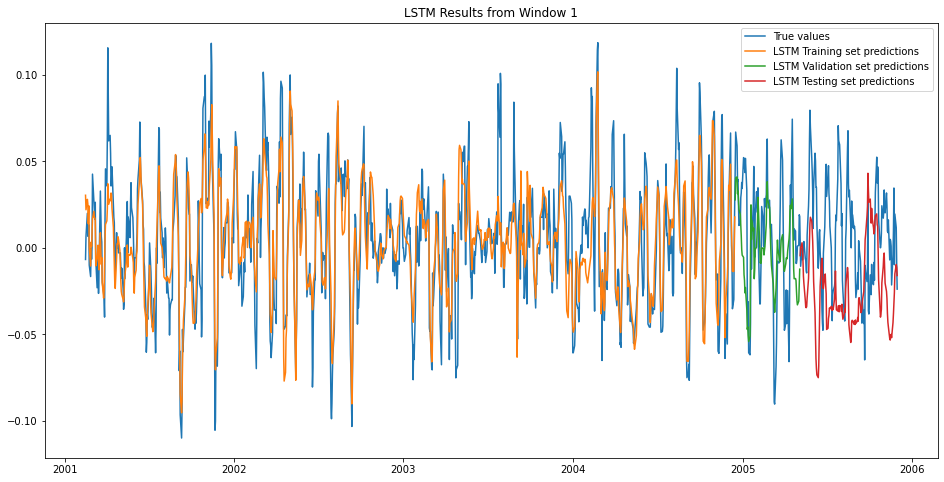

Window 2: 
Training datapoints: 150 - 1149
Validation datapoints: 1150 - 1249
Testing datapoints: 1250 - 1399

Results on Training set: 
MSE = 0.001211506052511822
RMSE = 0.03480669551267144
MAE = 0.026873504910287074
R-Squared = 0.12650001983517267

Results on Validation set: 
MSE = 0.0007680573991993967
RMSE = 0.027713848509353527
MAE = 0.02264431135136272
R-Squared = 0.029460448628682467

Results on Testing set: 
MSE = 0.0009667539413513407
RMSE = 0.031092667002869674
MAE = 0.02462001349701162
R-Squared = 0.05632615771264382



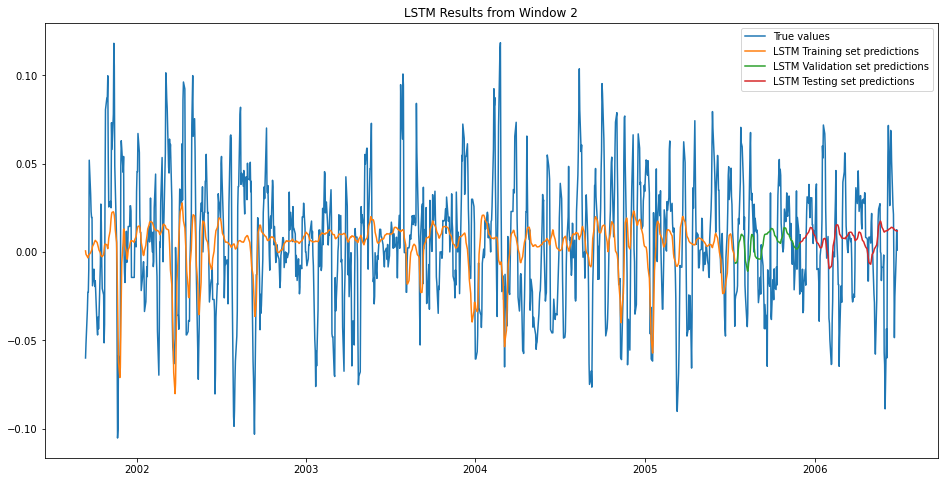

Window 3: 
Training datapoints: 300 - 1299
Validation datapoints: 1300 - 1399
Testing datapoints: 1400 - 1549

Results on Training set: 
MSE = 0.001109333825972101
RMSE = 0.033306663386957584
MAE = 0.025763757611521748
R-Squared = 0.10942304687077875

Results on Validation set: 
MSE = 0.0009610399076481896
RMSE = 0.03100064366506266
MAE = 0.024101467589328896
R-Squared = 0.0540023308884765

Results on Testing set: 
MSE = 0.0006777330910571116
RMSE = 0.026033307339965693
MAE = 0.02028605271871117
R-Squared = -0.01190415408220069



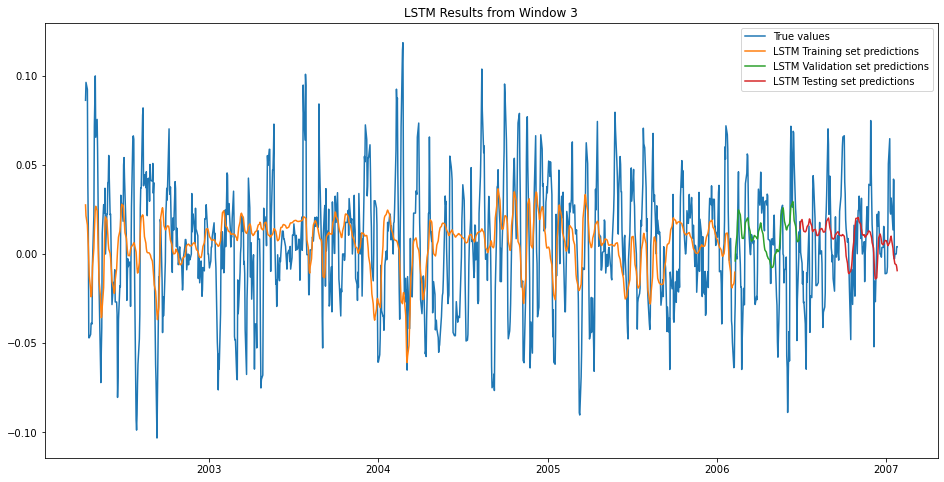

Window 4: 
Training datapoints: 450 - 1449
Validation datapoints: 1450 - 1549
Testing datapoints: 1550 - 1699

Results on Training set: 
MSE = 0.0010432954634478106
RMSE = 0.0323000845733848
MAE = 0.025129969667741094
R-Squared = 0.05772011163416879

Results on Validation set: 
MSE = 0.0004717075002973413
RMSE = 0.021718828244114398
MAE = 0.01635611539440638
R-Squared = 0.12404565316589222

Results on Testing set: 
MSE = 0.001341529929002469
RMSE = 0.03662690171175374
MAE = 0.02762108622083119
R-Squared = -0.0852512220418864



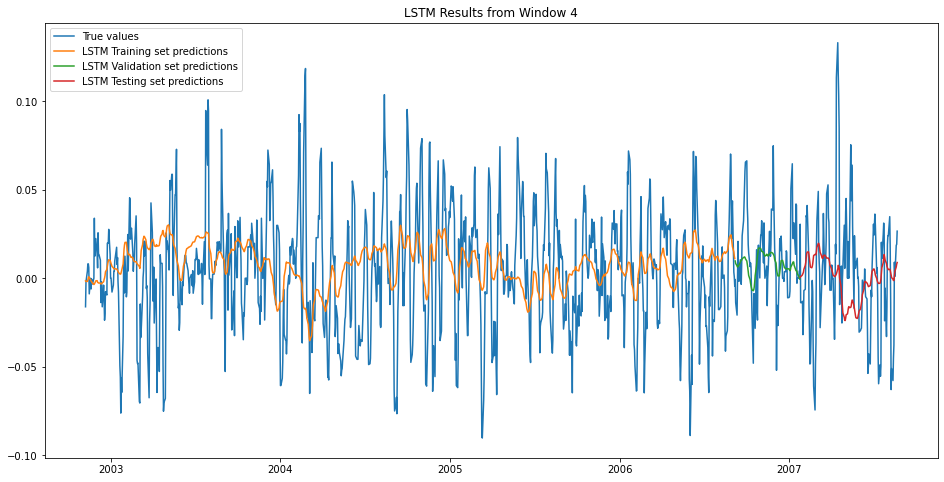

Window 5: 
Training datapoints: 600 - 1599
Validation datapoints: 1600 - 1699
Testing datapoints: 1700 - 1849

Results on Training set: 
MSE = 0.0009212092862061214
RMSE = 0.030351429722603206
MAE = 0.023411397831884086
R-Squared = 0.140701262195434

Results on Validation set: 
MSE = 0.00132198116680548
RMSE = 0.03635905893729209
MAE = 0.027922407211513862
R-Squared = 0.06964726603349136

Results on Testing set: 
MSE = 0.0030510768530015962
RMSE = 0.05523655359453191
MAE = 0.04395136030719561
R-Squared = -1.5144288382396511



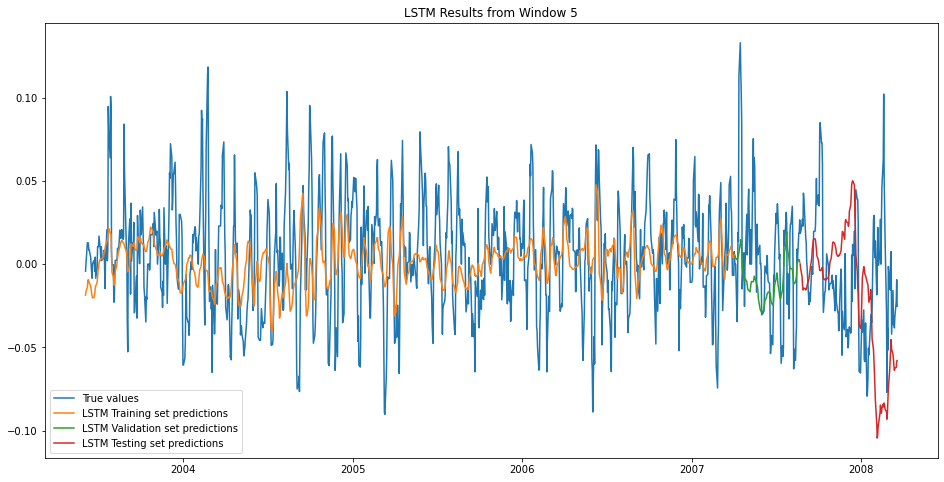

Window 6: 
Training datapoints: 750 - 1749
Validation datapoints: 1750 - 1849
Testing datapoints: 1850 - 1999

Results on Training set: 
MSE = 0.0007499061553623931
RMSE = 0.02738441446082777
MAE = 0.02108305384261318
R-Squared = 0.34950729308769957

Results on Validation set: 
MSE = 0.0019916448579388947
RMSE = 0.04462784845742504
MAE = 0.03651894166685419
R-Squared = -0.8112075789286577

Results on Testing set: 
MSE = 0.006794725058209053
RMSE = 0.0824301222746215
MAE = 0.07016612674364182
R-Squared = -2.9905607572285193



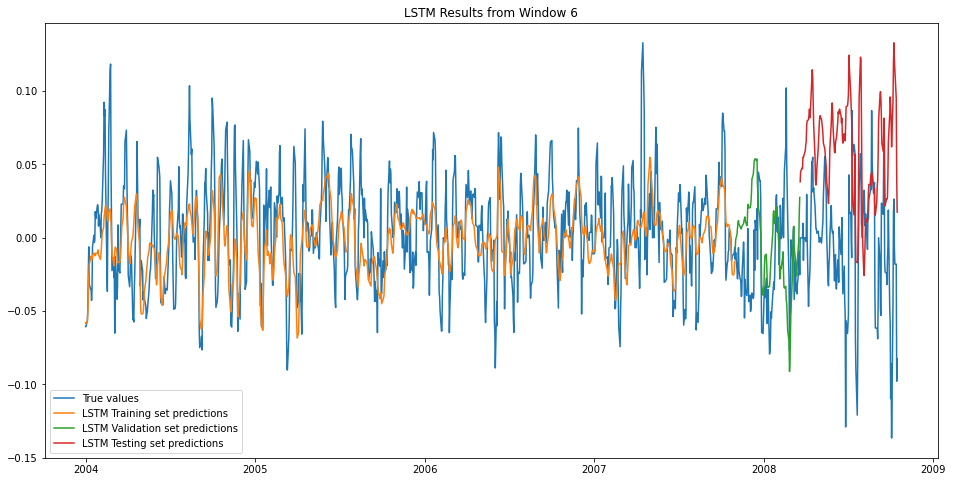

Window 7: 
Training datapoints: 900 - 1899
Validation datapoints: 1900 - 1999
Testing datapoints: 2000 - 2149

Results on Training set: 
MSE = 0.0010290928473917665
RMSE = 0.032079477043614135
MAE = 0.025340326322884497
R-Squared = 0.07935540889426285

Results on Validation set: 
MSE = 0.0025315300259686597
RMSE = 0.05031431233723323
MAE = 0.038626999715546145
R-Squared = -0.16285140582813673

Results on Testing set: 
MSE = 0.004325271583695095
RMSE = 0.0657667969700144
MAE = 0.05543029417100411
R-Squared = -0.8595635050488308



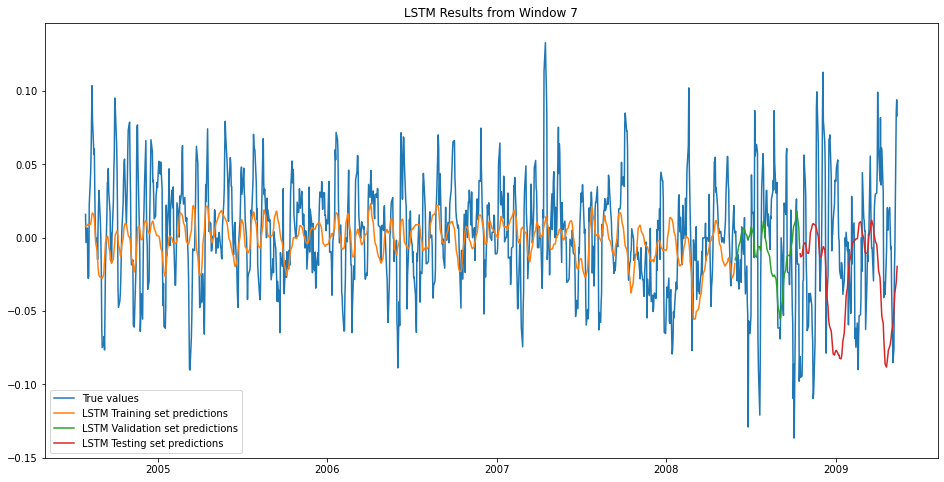

Window 8: 
Training datapoints: 1050 - 2049
Validation datapoints: 2050 - 2149
Testing datapoints: 2150 - 2299

Results on Training set: 
MSE = 0.0007390152127281902
RMSE = 0.027184834241322682
MAE = 0.02047401160719058
R-Squared = 0.42151082119343075

Results on Validation set: 
MSE = 0.0017794466688556775
RMSE = 0.04218348810678981
MAE = 0.030393653025603914
R-Squared = -0.022954972113430117

Results on Testing set: 
MSE = 0.0027431433786844744
RMSE = 0.052375026288150675
MAE = 0.043545808071214914
R-Squared = -1.1357177538121541



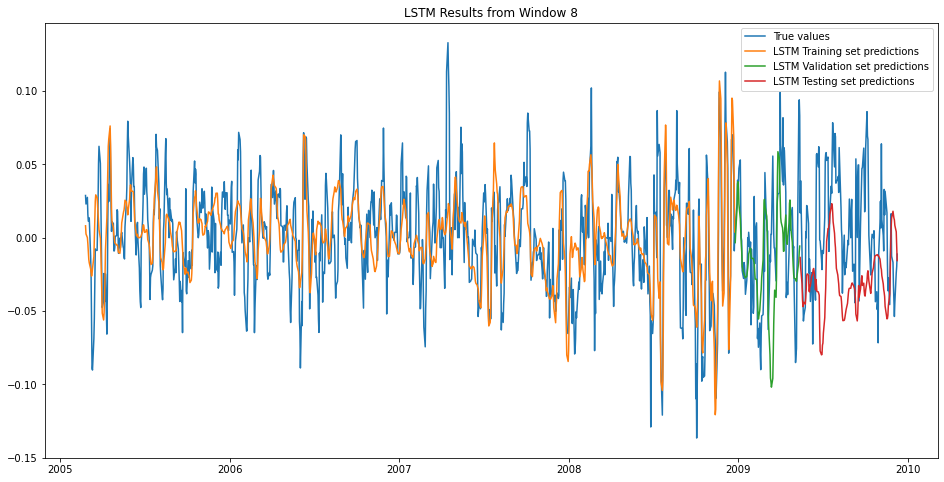

Window 9: 
Training datapoints: 1200 - 2199
Validation datapoints: 2200 - 2299
Testing datapoints: 2300 - 2449

Results on Training set: 
MSE = 0.0013194404398419765
RMSE = 0.036324102739668275
MAE = 0.028038945382021625
R-Squared = 0.018620671747200168

Results on Validation set: 
MSE = 0.0014456863999640329
RMSE = 0.03802218299840283
MAE = 0.031034335121466854
R-Squared = -0.15414246284932154

Results on Testing set: 
MSE = 0.0007678735306967197
RMSE = 0.027710531043210265
MAE = 0.02190304228258684
R-Squared = -0.13979133110681818



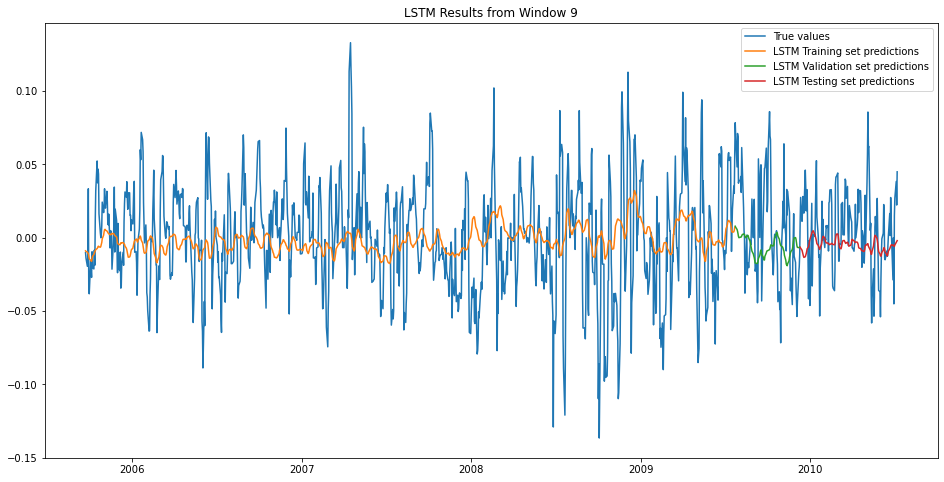

Window 10: 
Training datapoints: 1350 - 2349
Validation datapoints: 2350 - 2449
Testing datapoints: 2450 - 2599

Results on Training set: 
MSE = 0.0009237649294574842
RMSE = 0.030393501434640337
MAE = 0.022884457644532504
R-Squared = 0.33257044824691195

Results on Validation set: 
MSE = 0.0006961541168724348
RMSE = 0.026384732647355646
MAE = 0.020209696757017892
R-Squared = 0.052116244662829825

Results on Testing set: 
MSE = 0.00036529661394688485
RMSE = 0.019112734339881483
MAE = 0.014785378896580577
R-Squared = -0.1830528766969215



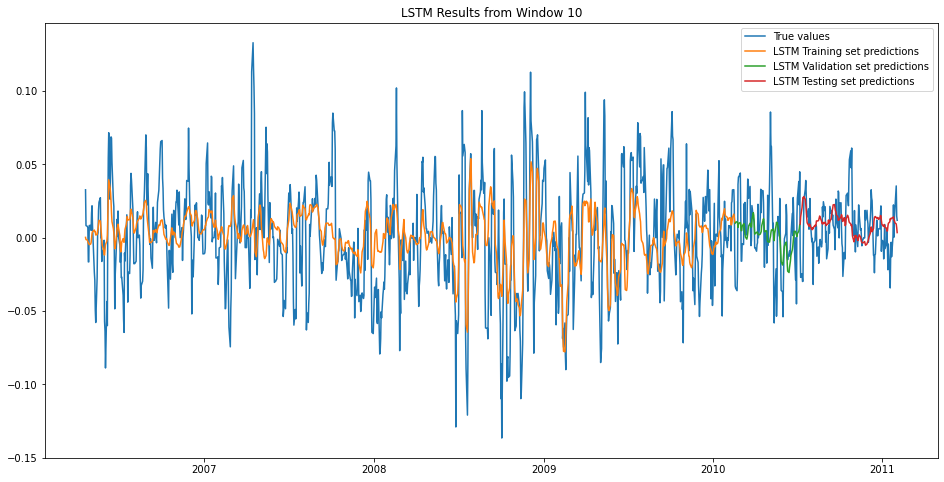

Window 11: 
Training datapoints: 1500 - 2499
Validation datapoints: 2500 - 2599
Testing datapoints: 2600 - 2749

Results on Training set: 
MSE = 0.0012537693534144245
RMSE = 0.03540860564064087
MAE = 0.026843292231610298
R-Squared = 0.06353867287678427

Results on Validation set: 
MSE = 0.00033625707879127593
RMSE = 0.018337313837944638
MAE = 0.013774669222239928
R-Squared = -0.06431121455507838

Results on Testing set: 
MSE = 0.0006709749484427108
RMSE = 0.0259031841371425
MAE = 0.019142922713861102
R-Squared = -0.2620722819772121



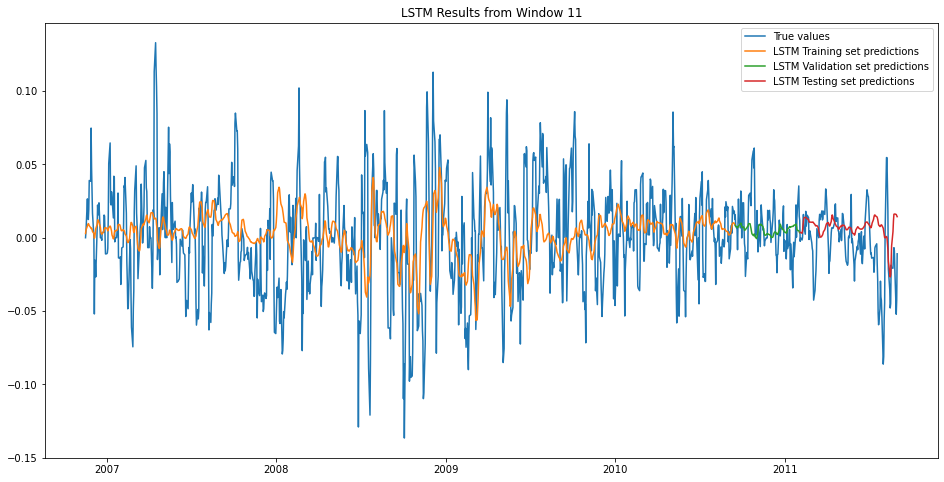

Window 12: 
Training datapoints: 1650 - 2649
Validation datapoints: 2650 - 2749
Testing datapoints: 2750 - 2899

Results on Training set: 
MSE = 0.0009102545789576069
RMSE = 0.030170425568055995
MAE = 0.022379935977031588
R-Squared = 0.2551061244822823

Results on Validation set: 
MSE = 0.000557352205988311
RMSE = 0.023608307986560814
MAE = 0.017388814427077137
R-Squared = 0.11333239359532299

Results on Testing set: 
MSE = 0.0004785757428504478
RMSE = 0.021876374079139525
MAE = 0.016320522419581464
R-Squared = -0.4985520115010169



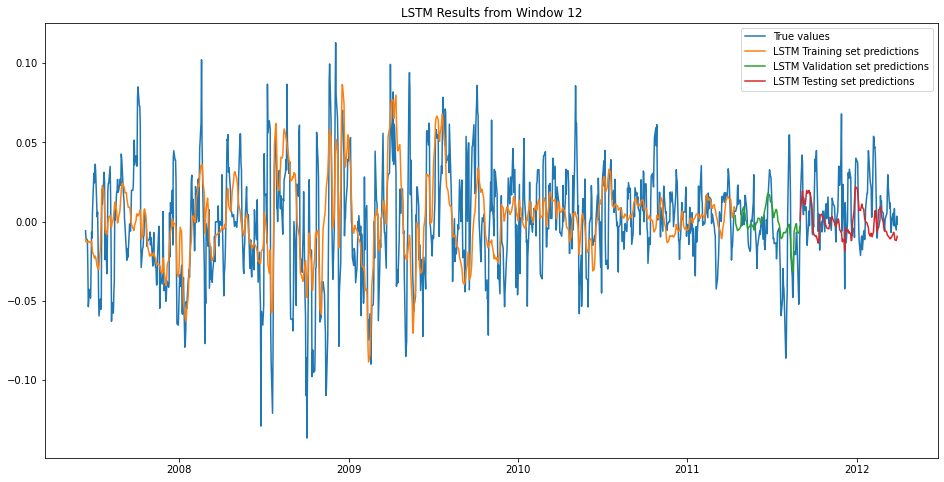

Window 13: 
Training datapoints: 1800 - 2799
Validation datapoints: 2800 - 2899
Testing datapoints: 2900 - 3049

Results on Training set: 
MSE = 0.0009358381440614364
RMSE = 0.030591471753765566
MAE = 0.022491248319575264
R-Squared = 0.17772923487515668

Results on Validation set: 
MSE = 0.0004379276101409555
RMSE = 0.02092672000436178
MAE = 0.015119017683599285
R-Squared = -0.18408435855019456

Results on Testing set: 
MSE = 0.0006953153019811036
RMSE = 0.026368832017764906
MAE = 0.021600694214794623
R-Squared = -0.19844797882168397



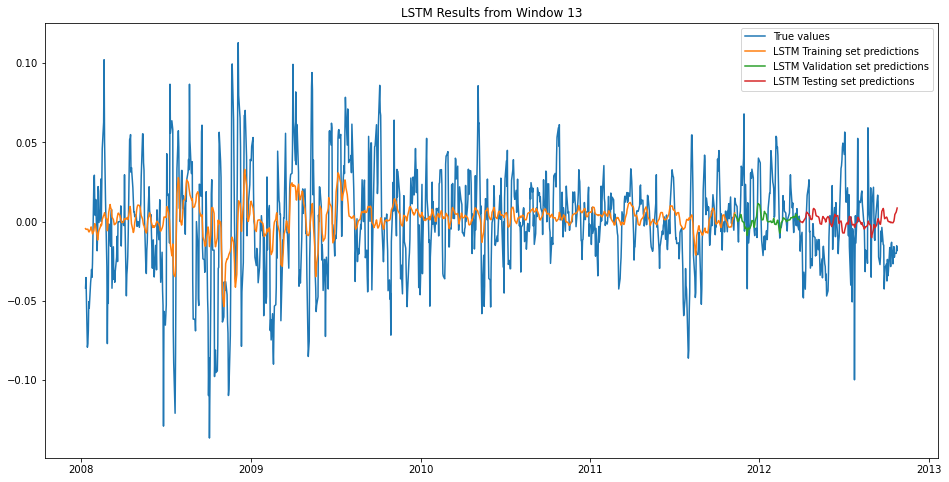

Window 14: 
Training datapoints: 1950 - 2949
Validation datapoints: 2950 - 3049
Testing datapoints: 3050 - 3199

Results on Training set: 
MSE = 0.0010438573418826923
RMSE = 0.03230878118844306
MAE = 0.02450985729659489
R-Squared = -0.045704035903751716

Results on Validation set: 
MSE = 0.0006752862220899483
RMSE = 0.025986269876416435
MAE = 0.01963993250694686
R-Squared = -0.04381672322666441

Results on Testing set: 
MSE = 0.0011566185875944567
RMSE = 0.03400909565975633
MAE = 0.02494885034206538
R-Squared = -0.4461602246161456



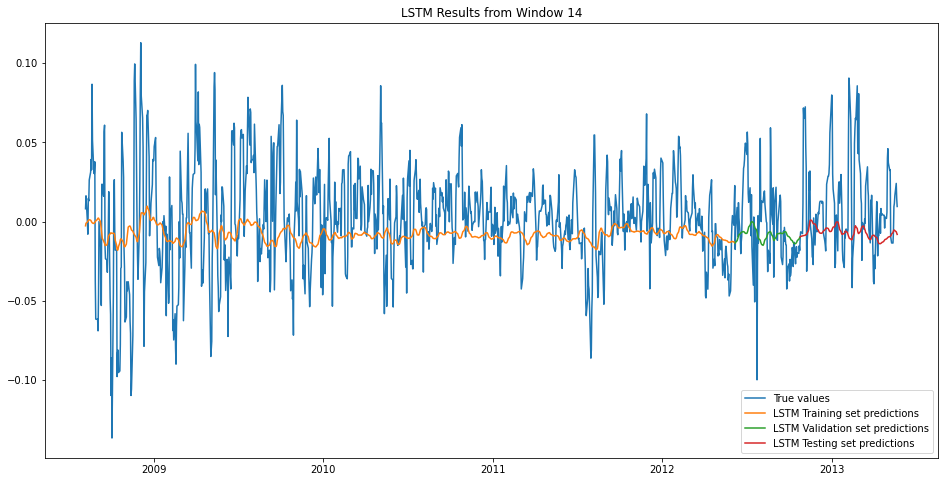

Window 15: 
Training datapoints: 2100 - 3099
Validation datapoints: 3100 - 3199
Testing datapoints: 3200 - 3349

Results on Training set: 
MSE = 0.0007217213777790339
RMSE = 0.026864872562121597
MAE = 0.020305396490088314
R-Squared = 0.02034860716512188

Results on Validation set: 
MSE = 0.0007970323648540886
RMSE = 0.028231761632142062
MAE = 0.020932724093230593
R-Squared = -0.023392163790607157

Results on Testing set: 
MSE = 0.0005115946819880307
RMSE = 0.022618458877386644
MAE = 0.017677106356966954
R-Squared = 0.04302643058571087



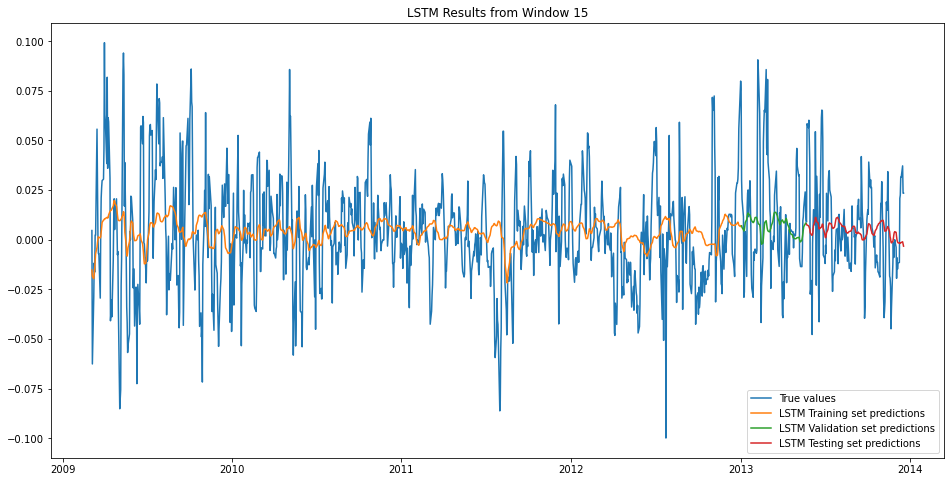

Window 16: 
Training datapoints: 2250 - 3249
Validation datapoints: 3250 - 3349
Testing datapoints: 3350 - 3499

Results on Training set: 
MSE = 0.00043325005624807763
RMSE = 0.020814659647663655
MAE = 0.01546885751989889
R-Squared = 0.3158918204028106

Results on Validation set: 
MSE = 0.0002748586160643496
RMSE = 0.016578860517669772
MAE = 0.013370419905805371
R-Squared = 0.21678493584307668

Results on Testing set: 
MSE = 0.0004396796254276643
RMSE = 0.020968538943561717
MAE = 0.016289515259268788
R-Squared = -0.26342274063942783



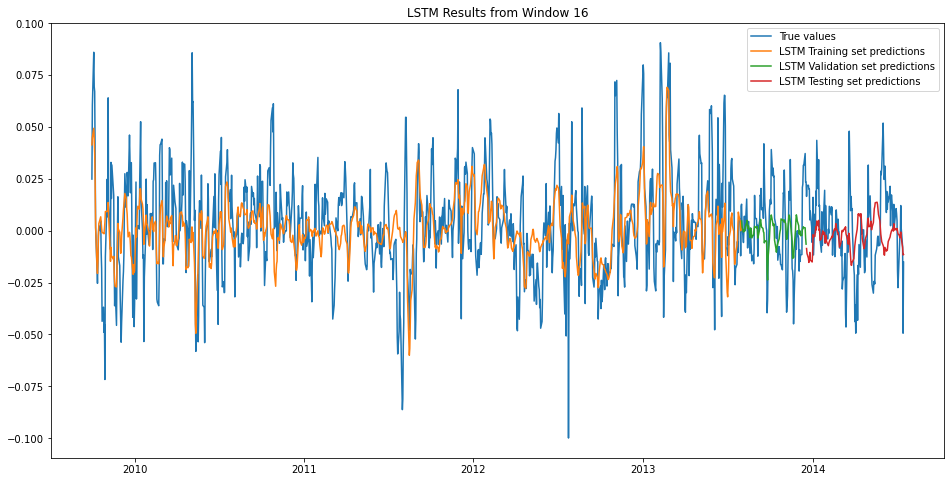

Window 17: 
Training datapoints: 2400 - 3399
Validation datapoints: 3400 - 3499
Testing datapoints: 3500 - 3649

Results on Training set: 
MSE = 0.0005929631600712457
RMSE = 0.02435083489474736
MAE = 0.018589463300295053
R-Squared = -0.05070470419608619

Results on Validation set: 
MSE = 0.0004399990646529045
RMSE = 0.020976154667929594
MAE = 0.016011834536506533
R-Squared = -0.03374633388198234

Results on Testing set: 
MSE = 0.000749716058431597
RMSE = 0.027380943344442993
MAE = 0.021177409292541347
R-Squared = -0.04271197398624671



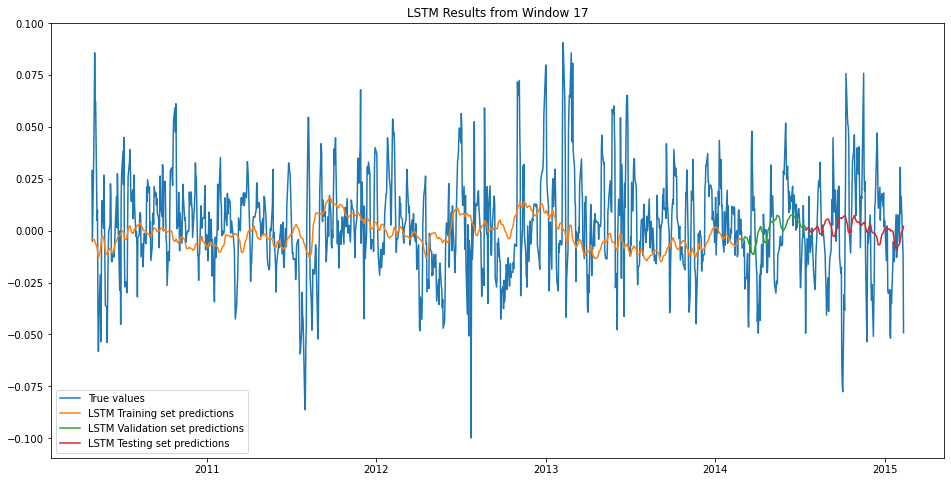

Window 18: 
Training datapoints: 2550 - 3549
Validation datapoints: 3550 - 3649
Testing datapoints: 3650 - 3799

Results on Training set: 
MSE = 0.0004084229998802361
RMSE = 0.020209477971492387
MAE = 0.01453749163883456
R-Squared = 0.24465650296182928

Results on Validation set: 
MSE = 0.0008628775941496149
RMSE = 0.029374778197453932
MAE = 0.022834906907426292
R-Squared = 0.04061275949119891

Results on Testing set: 
MSE = 0.0015372779799062426
RMSE = 0.039208136654350745
MAE = 0.030436044926447827
R-Squared = -0.38588196592329926



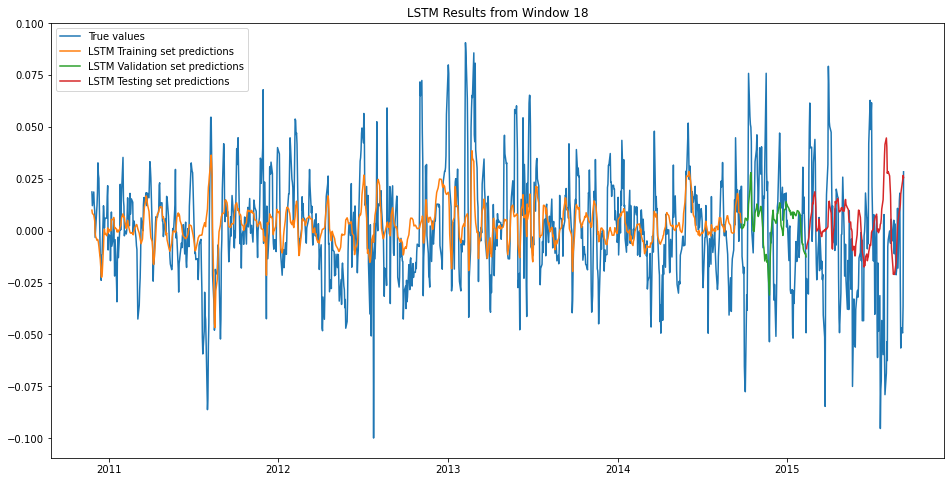

Window 19: 
Training datapoints: 2700 - 3699
Validation datapoints: 3700 - 3799
Testing datapoints: 3800 - 3949

Results on Training set: 
MSE = 0.0007810676132625853
RMSE = 0.027947586895161188
MAE = 0.02151432596469695
R-Squared = -0.19811977752685261

Results on Validation set: 
MSE = 0.0011822702229068599
RMSE = 0.034384156568205364
MAE = 0.02631246842297033
R-Squared = -0.246228582040942

Results on Testing set: 
MSE = 0.0019606118032720844
RMSE = 0.04427879631688382
MAE = 0.035436464615361
R-Squared = -0.08625238908842592



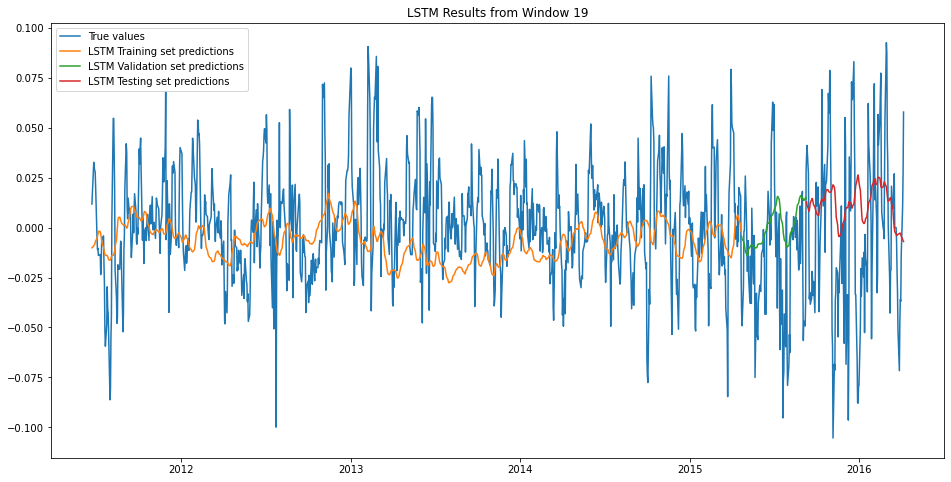

Window 20: 
Training datapoints: 2850 - 3849
Validation datapoints: 3850 - 3949
Testing datapoints: 3950 - 4099

Results on Training set: 
MSE = 0.0006807590472696694
RMSE = 0.026091359628614016
MAE = 0.019376792127253042
R-Squared = 0.10802057802674259

Results on Validation set: 
MSE = 0.0018841703761015558
RMSE = 0.043407031413142685
MAE = 0.03439035647495042
R-Squared = 0.007810959523577465

Results on Testing set: 
MSE = 0.0011087474384543934
RMSE = 0.03329785936744874
MAE = 0.025974891086051746
R-Squared = -0.22880494686680874



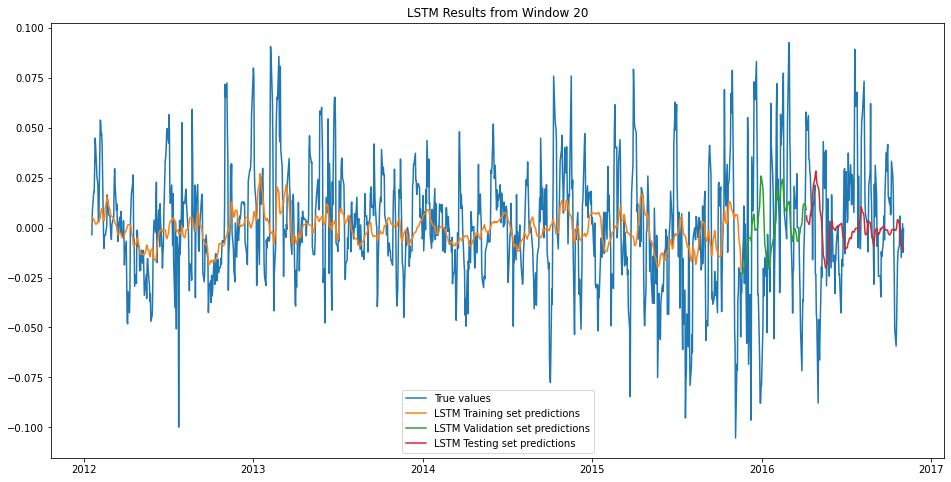

Window 21: 
Training datapoints: 3000 - 3999
Validation datapoints: 4000 - 4099
Testing datapoints: 4100 - 4249

Results on Training set: 
MSE = 0.00091424851970172
RMSE = 0.030236542786861727
MAE = 0.02286348571267863
R-Squared = -0.0023802368038219335

Results on Validation set: 
MSE = 0.0008354024942190416
RMSE = 0.02890333015794273
MAE = 0.022605410813855153
R-Squared = -0.03303675717942367

Results on Testing set: 
MSE = 0.0004080977483743954
RMSE = 0.02020142936463644
MAE = 0.016267454133130434
R-Squared = -0.041795587367196685



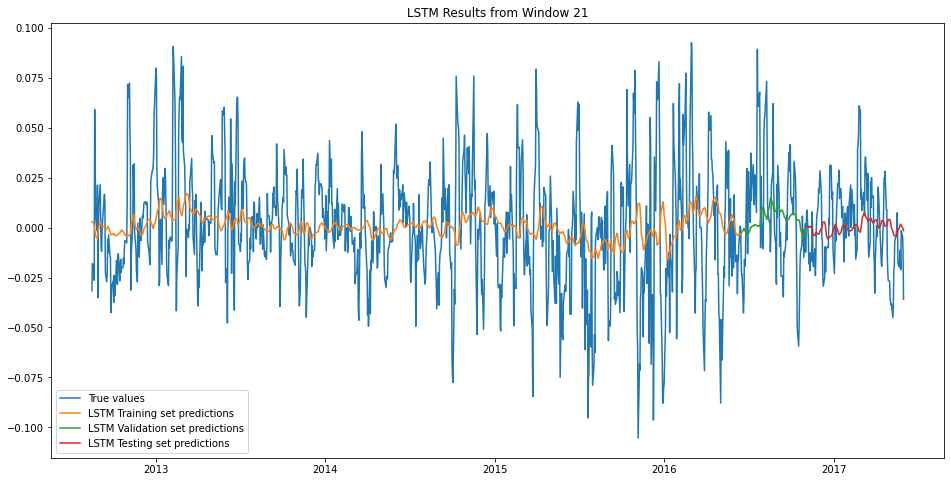

Window 22: 
Training datapoints: 3150 - 4149
Validation datapoints: 4150 - 4249
Testing datapoints: 4250 - 4399

Results on Training set: 
MSE = 0.0008304159875641749
RMSE = 0.028816939246980672
MAE = 0.021792527207188203
R-Squared = 0.041593707128220414

Results on Validation set: 
MSE = 0.0004885855905854142
RMSE = 0.02210397228068779
MAE = 0.017997416199922997
R-Squared = -0.098062300246057

Results on Testing set: 
MSE = 0.001161688312486013
RMSE = 0.03408354900074247
MAE = 0.024236613980441798
R-Squared = -0.16443973734657535



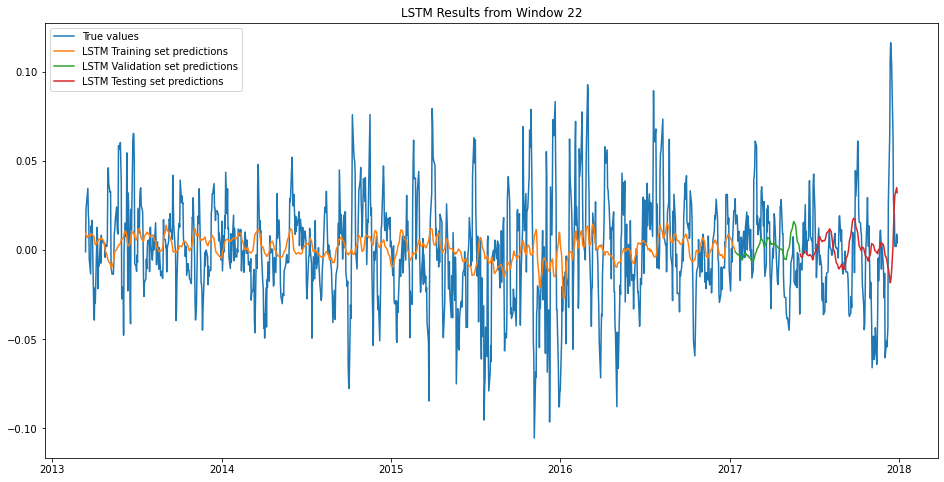

Window 23: 
Training datapoints: 3300 - 4299
Validation datapoints: 4300 - 4399
Testing datapoints: 4400 - 4549

Results on Training set: 
MSE = 0.0006229501643721498
RMSE = 0.024958969617597394
MAE = 0.018633539946188
R-Squared = 0.26291539847326484

Results on Validation set: 
MSE = 0.0010983688159684189
RMSE = 0.03314164775578334
MAE = 0.024734066481208027
R-Squared = 0.17982213238596234

Results on Testing set: 
MSE = 0.0008480182711654797
RMSE = 0.029120753272631524
MAE = 0.02341465301637837
R-Squared = -0.02736402955975814



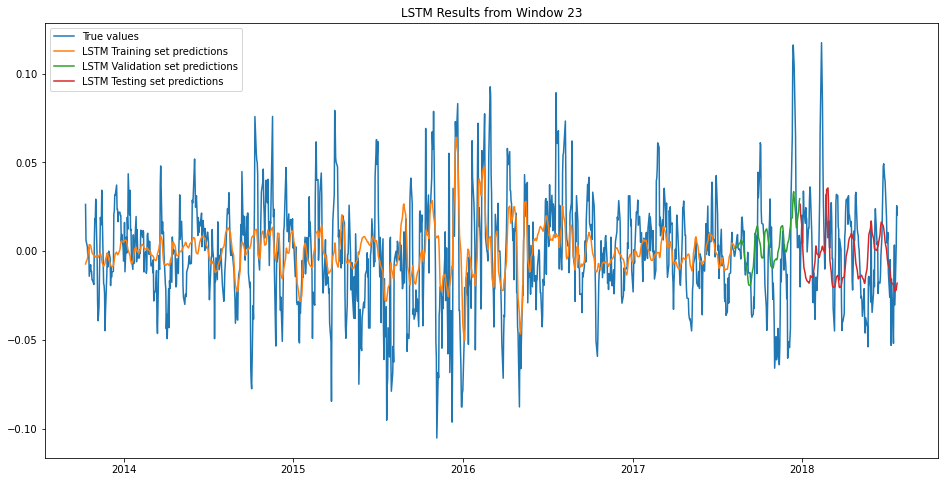

Window 24: 
Training datapoints: 3450 - 4449
Validation datapoints: 4450 - 4549
Testing datapoints: 4550 - 4699

Results on Training set: 
MSE = 0.0009617813142769532
RMSE = 0.031012599282822993
MAE = 0.02316945535254267
R-Squared = 0.02058401173652602

Results on Validation set: 
MSE = 0.0006534905642519939
RMSE = 0.025563461507628303
MAE = 0.02184107298328568
R-Squared = 0.0127028790113759

Results on Testing set: 
MSE = 0.0010134597852770814
RMSE = 0.03183488315161658
MAE = 0.024053766653863957
R-Squared = -0.054889219034868875



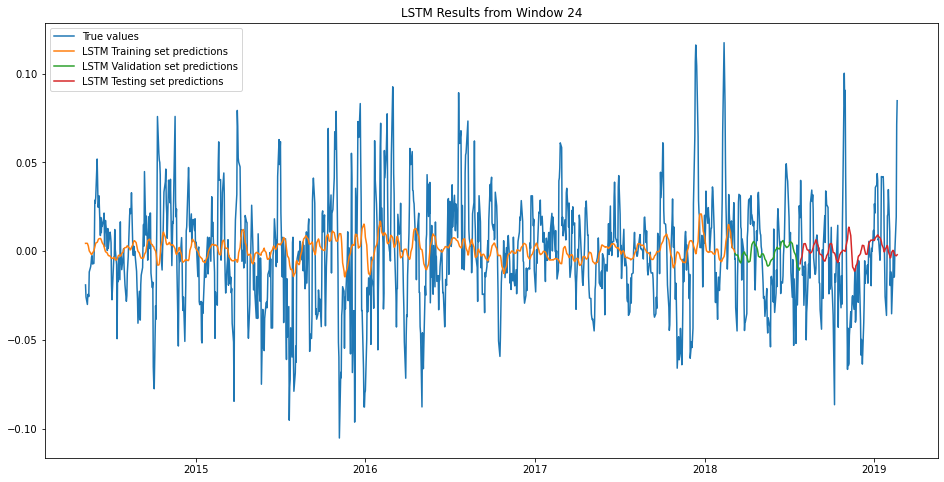

Window 25: 
Training datapoints: 3600 - 4599
Validation datapoints: 4600 - 4699
Testing datapoints: 4700 - 4918

Results on Training set: 
MSE = 0.0009316892602894268
RMSE = 0.030523585311844133
MAE = 0.023158336409372714
R-Squared = 0.04275952458720578

Results on Validation set: 
MSE = 0.0011502236880950169
RMSE = 0.03391494785629217
MAE = 0.02492683229568576
R-Squared = 0.04302657820992917

Results on Testing set: 
MSE = 0.0007306393962683304
RMSE = 0.027030342141162962
MAE = 0.019957031145992107
R-Squared = -0.07951675322303409



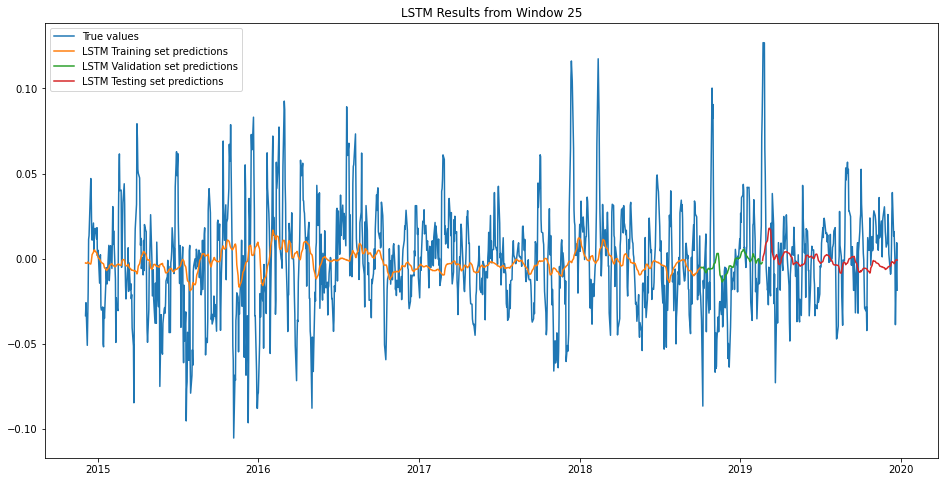

In [7]:
dataset = df.values
totaldatapoints = len(dataset)

#Declaring model parameters
sequencelength = 200
features = len(df.columns) - 1
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength
lstm_predictions = np.zeros((numPredictions + extra,1)) 
lstm_target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra

  #Print window information
  windowInfo(w, sequencelength, start, trainingSize, validationSize, end)
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #Create, train and test LSTM
  lstm_model = create_lstm()
  lstm_history, lstm_model = train_lstm(lstm_model, x_train, y_train, x_val, y_val)
  lstm_predictions, lstm_trainingPredictions, lstm_valPredictions, lstm_testingPredictions = makePredictions(lstm_model, lstm_predictions, x_train, x_val, x_test)
  evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, lstm_trainingPredictions, lstm_valPredictions, lstm_testingPredictions)

  lstm_target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Plot graph of forecasts
  trainGraph = pd.DataFrame(df[start : start + trainingSize])
  trainGraph['LSTM Train Predictions'] = lstm_trainingPredictions
  valGraph = pd.DataFrame(df[start + trainingSize : end - testingSize])
  valGraph['LSTM Val Predictions'] = lstm_valPredictions
  testGraph = pd.DataFrame(df[start + trainingSize + validationSize : end])
  testGraph['LSTM Test Predictions'] = lstm_testingPredictions

  #Plot LSTM Results
  plt.figure(figsize=(16,8))
  plt.plot(df['Target'][start : end], label='True values')
  plt.plot(trainGraph['LSTM Train Predictions'], label = 'LSTM Training set predictions')
  plt.plot(valGraph['LSTM Val Predictions'], label = 'LSTM Validation set predictions')
  plt.plot(testGraph['LSTM Test Predictions'], label = 'LSTM Testing set predictions')
  plt.title("LSTM Results from Window " + str(w + 1))
  plt.legend(loc = 'best')
  plt.show()

  #Update window parameters
  start += testingSize
  end += testingSize

In [8]:
K.clear_session()
tf.compat.v1.reset_default_graph()

**GRU model**

In [9]:
def create_gru():
  '''
  Function to create an GRU using the Keras Framework
  @returns
    model - Compiled GRU
  '''
  #hyperparameters
  learningRate = 0.01
  dropout = 0.0
  units = 46

  #Construct GRU
  model = Sequential()
  model.add(GRU(units=units, return_sequences=True, input_shape=(sequencelength, features)))
  model.add(GRU(units=units, dropout=dropout))
  model.add(Dense(1))

  #GRU compile
  ao = Adam(lr=learningRate, amsgrad=True)
  model.compile(loss='mae', optimizer=ao, metrics=['mse','mae', 'mape', 'msle'])

  return model

def train_gru(model, x_train, y_train, x_val, y_val):
  '''
  Function to train the LSTM
  @params:
    model - Keras LSTM model
    x_train - Training Input
    y_train - Training Output
    x_val - Validation Input
    y_val - Validation Output
  @returns:
    history - Model history
    model - Best model according to early stopping
  '''
  batchSize = 214
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20)
  mc = ModelCheckpoint('./GRU.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
  history = model.fit(x_train, y_train, epochs=150, batch_size=batchSize, verbose=0, validation_data = (x_val, y_val), callbacks=[es, mc])
  model = load_model('./GRU.h5')
  return history, model

**GRU Forecasting Implementation**

Window 1: 
Training datapoints: 0 - 999
Validation datapoints: 1000 - 1099
Testing datapoints: 1100 - 1249

Results on Training set: 
MSE = 0.0010924463906326416
RMSE = 0.033052176791138005
MAE = 0.02480491945371468
R-Squared = 0.2150101969863666

Results on Validation set: 
MSE = 0.0010531032886796161
RMSE = 0.032451552947118205
MAE = 0.02675814201001554
R-Squared = 0.22964732369219987

Results on Testing set: 
MSE = 0.0009745504131226505
RMSE = 0.03121779001022735
MAE = 0.02568805955382597
R-Squared = -0.18638985966314303



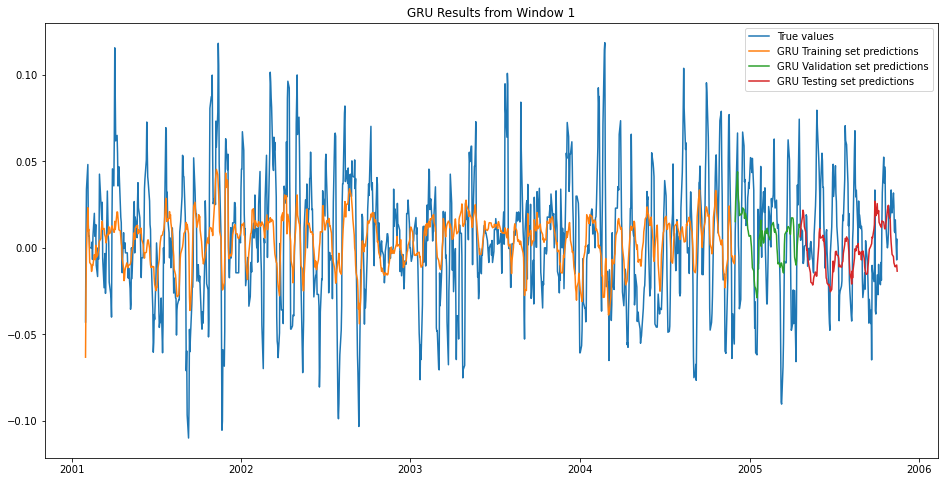

Window 2: 
Training datapoints: 150 - 1149
Validation datapoints: 1150 - 1249
Testing datapoints: 1250 - 1399

Results on Training set: 
MSE = 0.0011741035940490718
RMSE = 0.03426519508260637
MAE = 0.02610126198111988
R-Squared = 0.17746886375645865

Results on Validation set: 
MSE = 0.0008398679687909772
RMSE = 0.028980475648114838
MAE = 0.0240101711421705
R-Squared = 0.035006901243180955

Results on Testing set: 
MSE = 0.0009188020154639216
RMSE = 0.030311747152942565
MAE = 0.0244509956401137
R-Squared = 0.026789307087669134



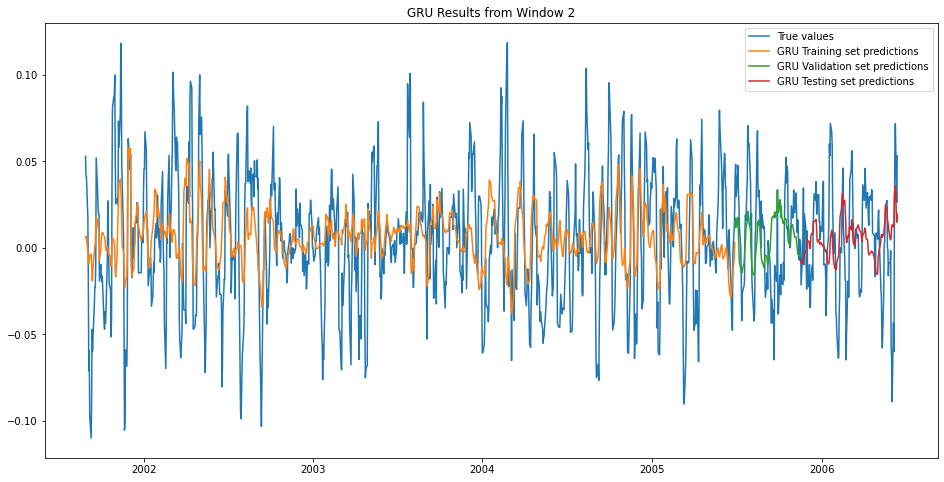

Window 3: 
Training datapoints: 300 - 1299
Validation datapoints: 1300 - 1399
Testing datapoints: 1400 - 1549

Results on Training set: 
MSE = 0.0011385251870589708
RMSE = 0.03374203886932399
MAE = 0.026229767327827027
R-Squared = 0.08187115132296718

Results on Validation set: 
MSE = 0.0009326795431834493
RMSE = 0.03053980260550892
MAE = 0.023813856479085963
R-Squared = 0.09691247113526902

Results on Testing set: 
MSE = 0.0006784965245081759
RMSE = 0.02604796584204179
MAE = 0.020381707417083207
R-Squared = 0.08408206273792285



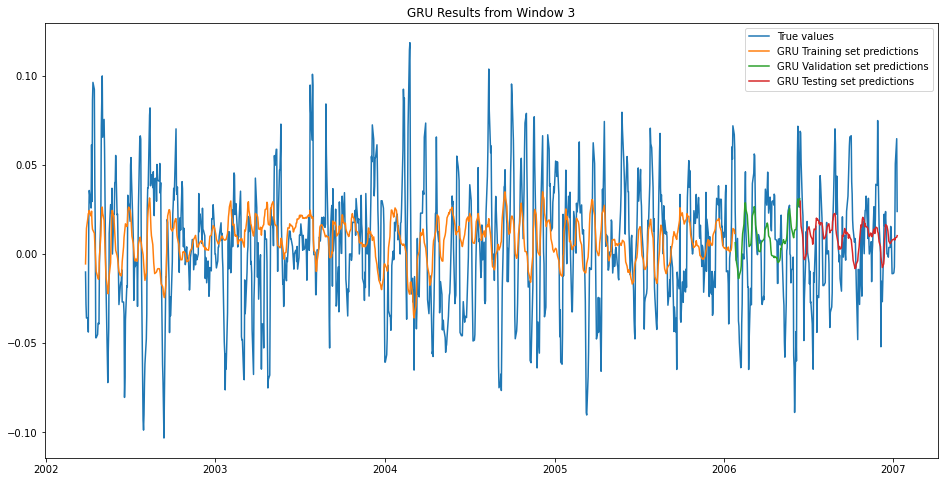

Window 4: 
Training datapoints: 450 - 1449
Validation datapoints: 1450 - 1549
Testing datapoints: 1550 - 1699

Results on Training set: 
MSE = 0.0010000204671355658
RMSE = 0.03162310021385579
MAE = 0.02413177180437065
R-Squared = 0.08803096766378826

Results on Validation set: 
MSE = 0.0005070729452400531
RMSE = 0.022518280246059046
MAE = 0.016933527327817683
R-Squared = 0.14442052220220203

Results on Testing set: 
MSE = 0.001410788845038288
RMSE = 0.03756046918022042
MAE = 0.028282187948764116
R-Squared = -0.22079439017842684



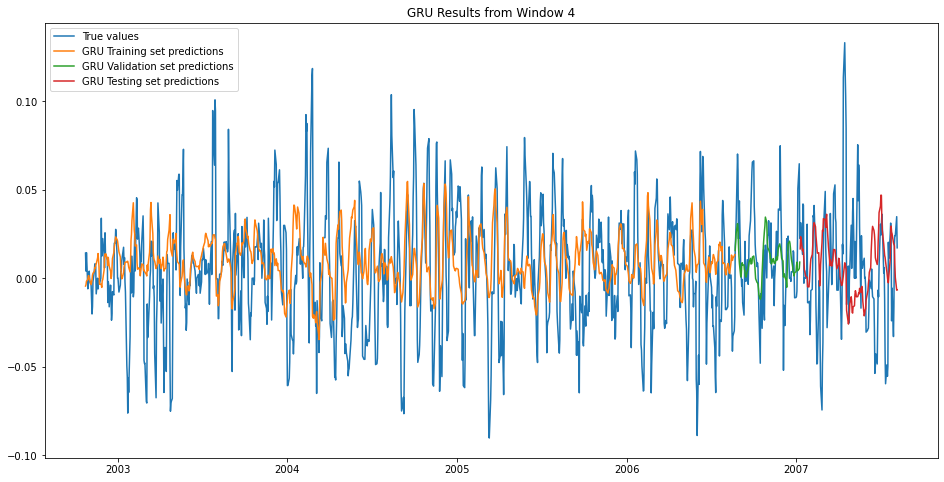

Window 5: 
Training datapoints: 600 - 1599
Validation datapoints: 1600 - 1699
Testing datapoints: 1700 - 1849

Results on Training set: 
MSE = 0.000995361455135058
RMSE = 0.03154934951999895
MAE = 0.024648614085565294
R-Squared = 0.07596989934901477

Results on Validation set: 
MSE = 0.0012777747923670103
RMSE = 0.035745975890539204
MAE = 0.026176531085092828
R-Squared = 0.01886910985589363

Results on Testing set: 
MSE = 0.0019566998837772694
RMSE = 0.044234600526932184
MAE = 0.035732389731874606
R-Squared = -0.5479357226946617



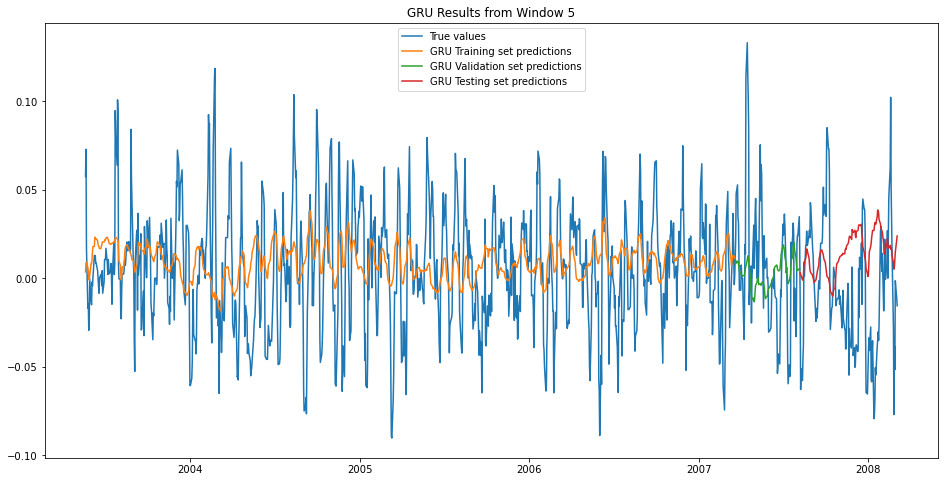

Window 6: 
Training datapoints: 750 - 1749
Validation datapoints: 1750 - 1849
Testing datapoints: 1850 - 1999

Results on Training set: 
MSE = 0.001610425975236168
RMSE = 0.040130113072805666
MAE = 0.0321806040502964
R-Squared = -0.39386270942869683

Results on Validation set: 
MSE = 0.0014596549887397924
RMSE = 0.0382054314036603
MAE = 0.03166298640713661
R-Squared = -0.3506506147825861

Results on Testing set: 
MSE = 0.0017904167096828665
RMSE = 0.04231331598543024
MAE = 0.03210518210826047
R-Squared = -0.2924193776418167



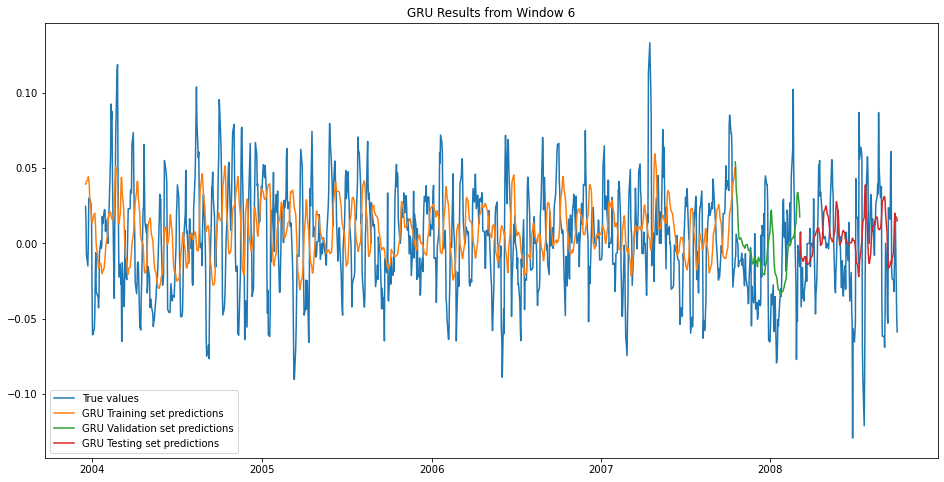

Window 7: 
Training datapoints: 900 - 1899
Validation datapoints: 1900 - 1999
Testing datapoints: 2000 - 2149

Results on Training set: 
MSE = 0.0010279179578663773
RMSE = 0.03206115964631313
MAE = 0.024952672865227836
R-Squared = 0.07933009741691432

Results on Validation set: 
MSE = 0.001876173248841286
RMSE = 0.04331481558129142
MAE = 0.0333038068926033
R-Squared = -0.07793627331433184

Results on Testing set: 
MSE = 0.0026146515588211365
RMSE = 0.05113366365537616
MAE = 0.041083115746576
R-Squared = -0.09837116796792955



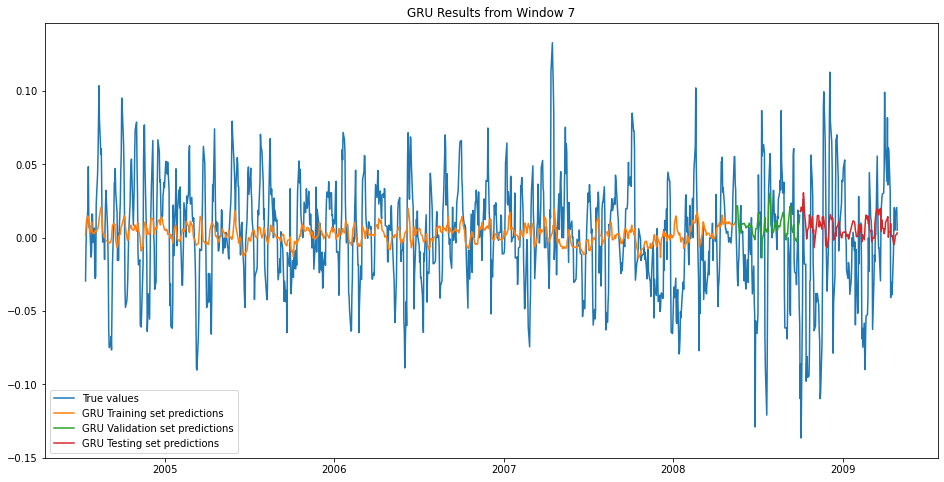

Window 8: 
Training datapoints: 1050 - 2049
Validation datapoints: 2050 - 2149
Testing datapoints: 2150 - 2299

Results on Training set: 
MSE = 0.001099488602496273
RMSE = 0.03315853739983525
MAE = 0.025014612321345914
R-Squared = 0.12885620643182316

Results on Validation set: 
MSE = 0.0011544192180014947
RMSE = 0.033976745253209505
MAE = 0.027714240891268626
R-Squared = 0.26014930459392915

Results on Testing set: 
MSE = 0.0019759809206126057
RMSE = 0.044452006935712204
MAE = 0.03482839796838889
R-Squared = -0.3171209723005619



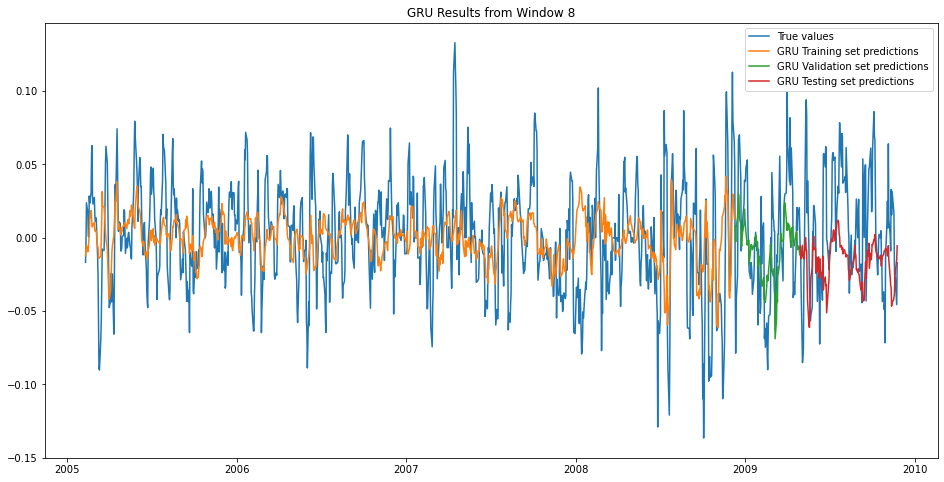

Window 9: 
Training datapoints: 1200 - 2199
Validation datapoints: 2200 - 2299
Testing datapoints: 2300 - 2449

Results on Training set: 
MSE = 0.001543686174611841
RMSE = 0.039289771882919364
MAE = 0.03025663776211335
R-Squared = -0.15422537744021714

Results on Validation set: 
MSE = 0.0012919792027072672
RMSE = 0.03594411221197802
MAE = 0.031047810815676247
R-Squared = -0.060725195170552526

Results on Testing set: 
MSE = 0.0009404547692754815
RMSE = 0.030666835005841105
MAE = 0.02401396860432269
R-Squared = -0.34588771294408427



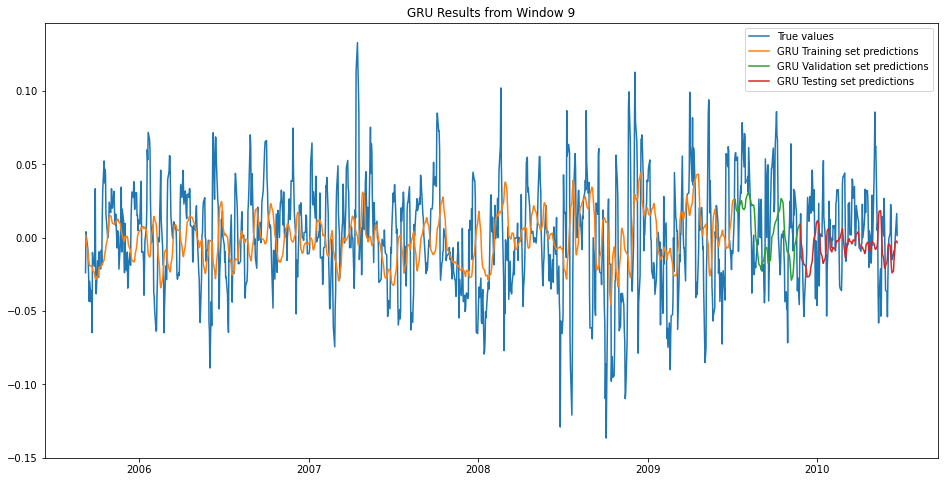

Window 10: 
Training datapoints: 1350 - 2349
Validation datapoints: 2350 - 2449
Testing datapoints: 2450 - 2599

Results on Training set: 
MSE = 0.0013037079614870897
RMSE = 0.036106896314791304
MAE = 0.028008698226406815
R-Squared = 0.06165714293691771

Results on Validation set: 
MSE = 0.0006108332591942013
RMSE = 0.02471504115299429
MAE = 0.018909573951463778
R-Squared = 0.11121595542467755

Results on Testing set: 
MSE = 0.00034371235781518084
RMSE = 0.01853948105571407
MAE = 0.01462256383559545
R-Squared = 0.004483482926542548



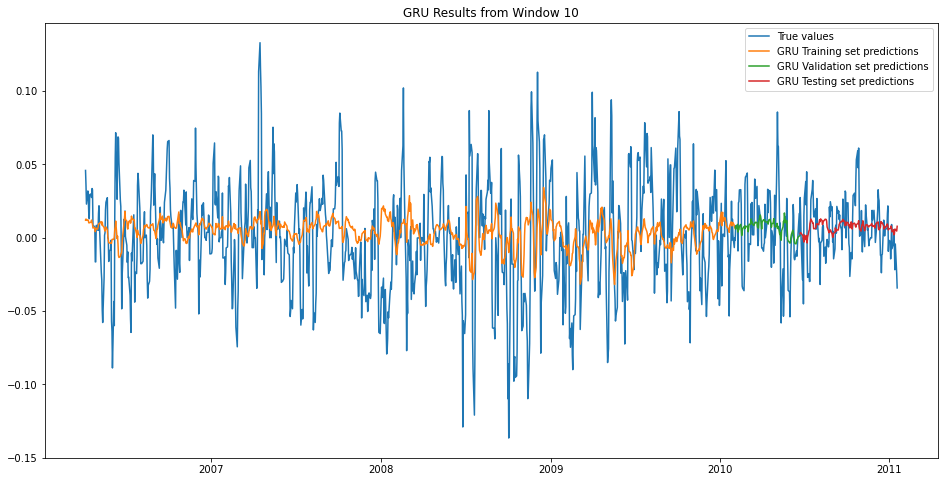

Window 11: 
Training datapoints: 1500 - 2499
Validation datapoints: 2500 - 2599
Testing datapoints: 2600 - 2749

Results on Training set: 
MSE = 0.000716950705165762
RMSE = 0.026775935187510484
MAE = 0.019791483826433216
R-Squared = 0.4653789146854618

Results on Validation set: 
MSE = 0.0002941738245260641
RMSE = 0.017151496276595346
MAE = 0.012411768407131128
R-Squared = 0.03849516355831306

Results on Testing set: 
MSE = 0.0008041789497928754
RMSE = 0.0283580491182464
MAE = 0.020236828937165417
R-Squared = -0.577020453630009



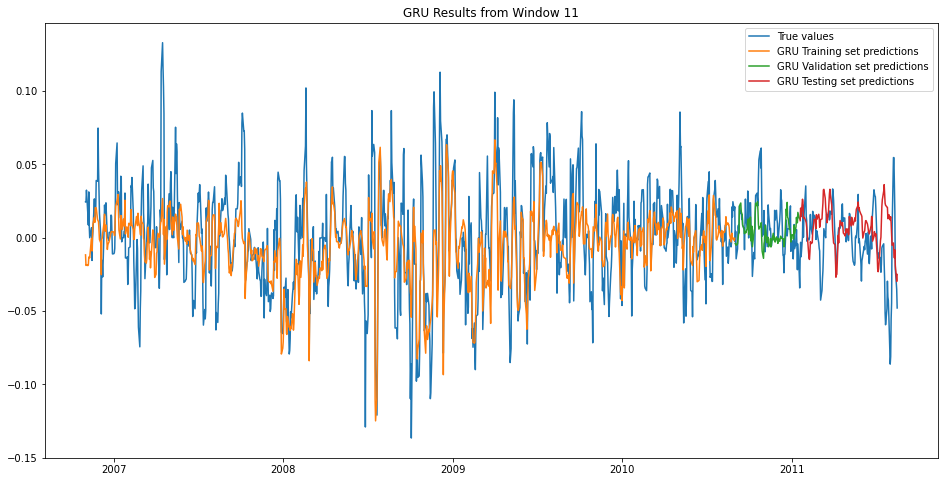

Window 12: 
Training datapoints: 1650 - 2649
Validation datapoints: 2650 - 2749
Testing datapoints: 2750 - 2899

Results on Training set: 
MSE = 0.0013474868952201681
RMSE = 0.0367081311867026
MAE = 0.02789391005632941
R-Squared = -0.10283130171766319

Results on Validation set: 
MSE = 0.0006216303905893061
RMSE = 0.024932516731956806
MAE = 0.017321251496603414
R-Squared = 4.793444451633988e-05

Results on Testing set: 
MSE = 0.000717005045804952
RMSE = 0.026776949897345515
MAE = 0.020748408236937323
R-Squared = -0.7755650095319018



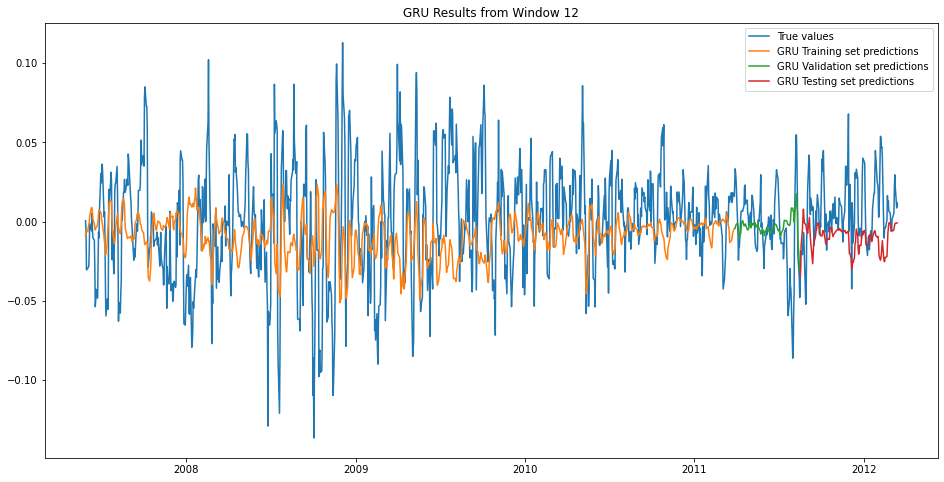

Window 13: 
Training datapoints: 1800 - 2799
Validation datapoints: 2800 - 2899
Testing datapoints: 2900 - 3049

Results on Training set: 
MSE = 0.0011010908849901223
RMSE = 0.033182689538223425
MAE = 0.02475667622314624
R-Squared = 0.05289940839023244

Results on Validation set: 
MSE = 0.0004307526756518926
RMSE = 0.020754582039922958
MAE = 0.015395083531632629
R-Squared = -0.1866553223146592

Results on Testing set: 
MSE = 0.000667431076275206
RMSE = 0.02583468746230939
MAE = 0.02055036253583042
R-Squared = -0.1665902887362698



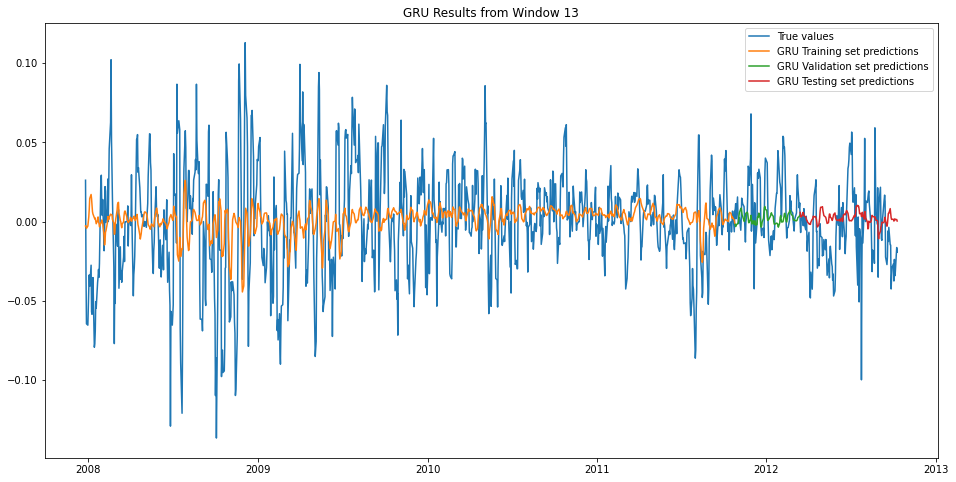

Window 14: 
Training datapoints: 1950 - 2949
Validation datapoints: 2950 - 3049
Testing datapoints: 3050 - 3199

Results on Training set: 
MSE = 0.0009737565572791971
RMSE = 0.03120507262095695
MAE = 0.023415132218324905
R-Squared = 0.0246357257877029

Results on Validation set: 
MSE = 0.0006757727216383047
RMSE = 0.02599562889484124
MAE = 0.02067747657656994
R-Squared = 0.021423144999236254

Results on Testing set: 
MSE = 0.001068321511713125
RMSE = 0.0326851879559094
MAE = 0.023821791088358954
R-Squared = -0.2554490676349823



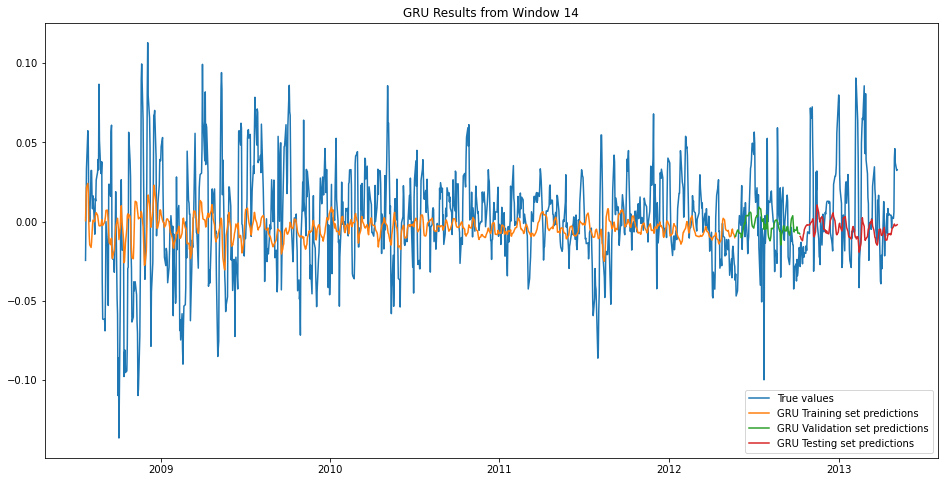

Window 15: 
Training datapoints: 2100 - 3099
Validation datapoints: 3100 - 3199
Testing datapoints: 3200 - 3349

Results on Training set: 
MSE = 0.000641831420292194
RMSE = 0.025334392045048053
MAE = 0.0190003465165572
R-Squared = 0.13021952639858692

Results on Validation set: 
MSE = 0.0009982561683288115
RMSE = 0.03159519217110115
MAE = 0.023789866656859095
R-Squared = -0.08925718091167578

Results on Testing set: 
MSE = 0.0004747957618182286
RMSE = 0.02178980866869254
MAE = 0.01683891282945233
R-Squared = 0.07783924103231854



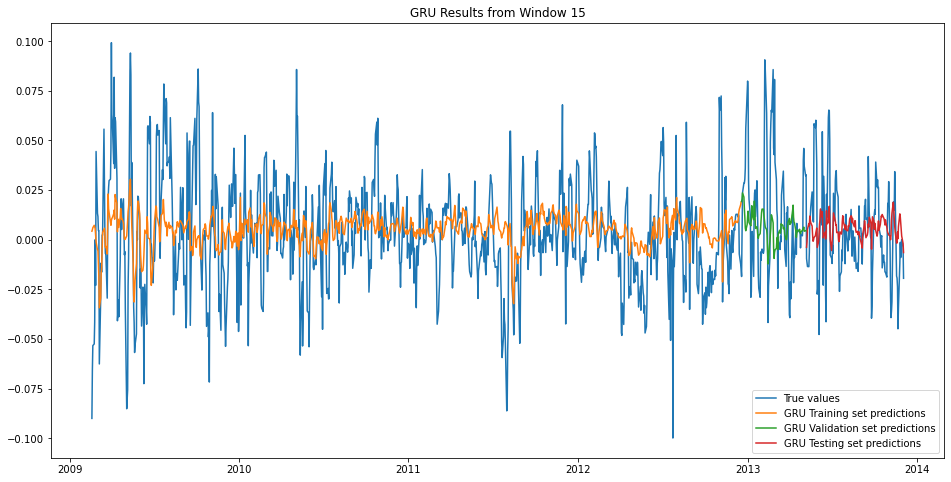

Window 16: 
Training datapoints: 2250 - 3249
Validation datapoints: 3250 - 3349
Testing datapoints: 3350 - 3499

Results on Training set: 
MSE = 0.0006415818800316673
RMSE = 0.025329466635357078
MAE = 0.018840944285682386
R-Squared = 0.008218376689934082

Results on Validation set: 
MSE = 0.0002816672803306649
RMSE = 0.016782946115943557
MAE = 0.013499126998185776
R-Squared = 0.1028967343666426

Results on Testing set: 
MSE = 0.00039197208648373785
RMSE = 0.019798284937936866
MAE = 0.01601904498307354
R-Squared = -0.10142016408076415



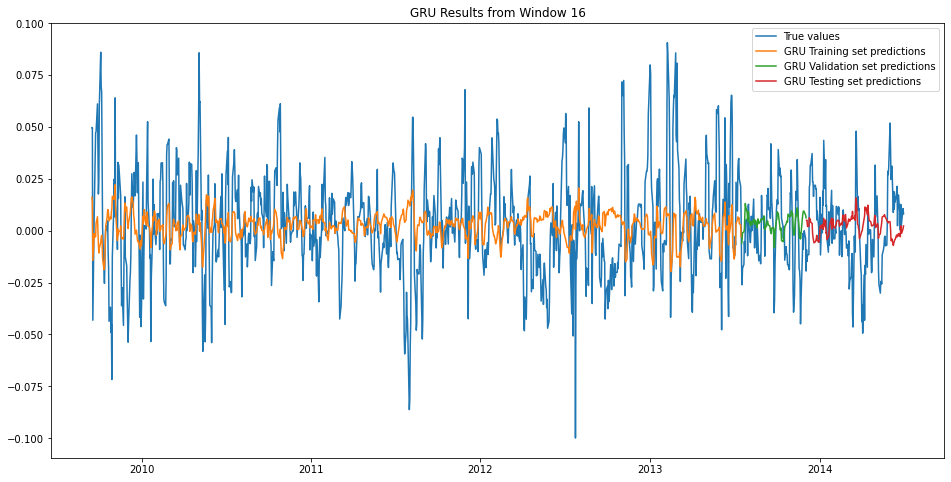

Window 17: 
Training datapoints: 2400 - 3399
Validation datapoints: 3400 - 3499
Testing datapoints: 3500 - 3649

Results on Training set: 
MSE = 0.0005299266725557466
RMSE = 0.023020136241033558
MAE = 0.01689569973313259
R-Squared = 0.06658921386795025

Results on Validation set: 
MSE = 0.0004622024533335774
RMSE = 0.021498894235136314
MAE = 0.01657257646405639
R-Squared = -0.16607788446938376

Results on Testing set: 
MSE = 0.0008262442465665434
RMSE = 0.028744464624802867
MAE = 0.022452831081123562
R-Squared = -0.15000911873258627



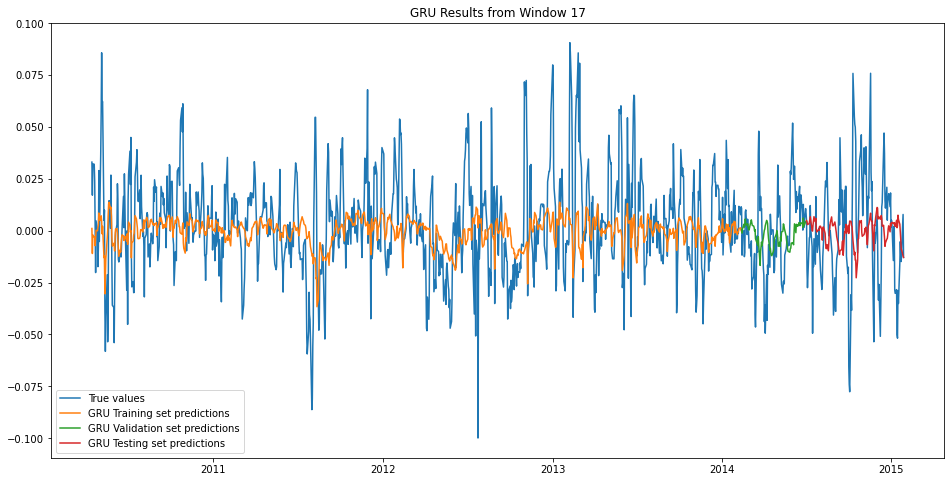

Window 18: 
Training datapoints: 2550 - 3549
Validation datapoints: 3550 - 3649
Testing datapoints: 3650 - 3799

Results on Training set: 
MSE = 0.0005384331824758767
RMSE = 0.023204163041917213
MAE = 0.01728839557605711
R-Squared = -0.0004447820110771161

Results on Validation set: 
MSE = 0.0008878834704521015
RMSE = 0.029797373549561402
MAE = 0.0236304660827338
R-Squared = -0.002088399358385784

Results on Testing set: 
MSE = 0.001108416285210189
RMSE = 0.033292886405509946
MAE = 0.025315524983762935
R-Squared = -0.02640917171755519



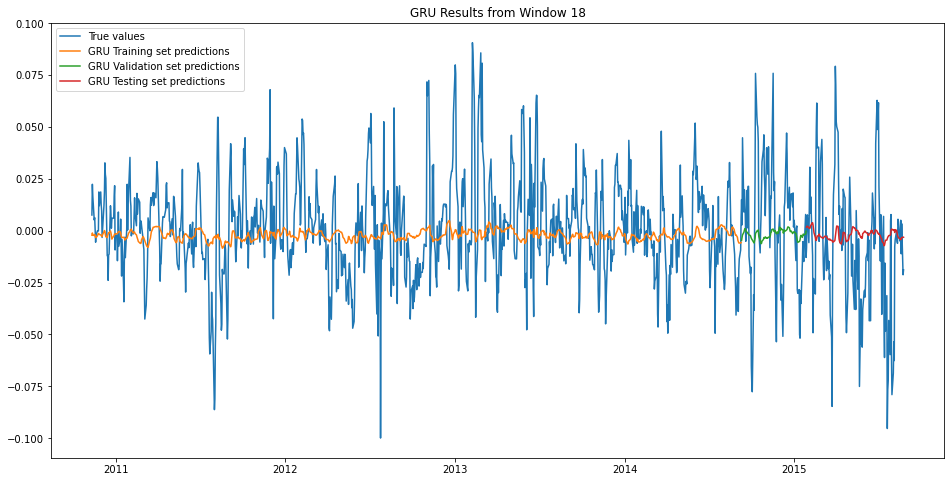

Window 19: 
Training datapoints: 2700 - 3699
Validation datapoints: 3700 - 3799
Testing datapoints: 3800 - 3949

Results on Training set: 
MSE = 0.0006634628908262654
RMSE = 0.025757773405833535
MAE = 0.019270225348416284
R-Squared = -0.01894062250236428

Results on Validation set: 
MSE = 0.0010106584151462887
RMSE = 0.03179085426889766
MAE = 0.02420367146749836
R-Squared = -0.09858115346914764

Results on Testing set: 
MSE = 0.001857549490447337
RMSE = 0.043099298027315214
MAE = 0.035475086942764376
R-Squared = -0.05490256423993034



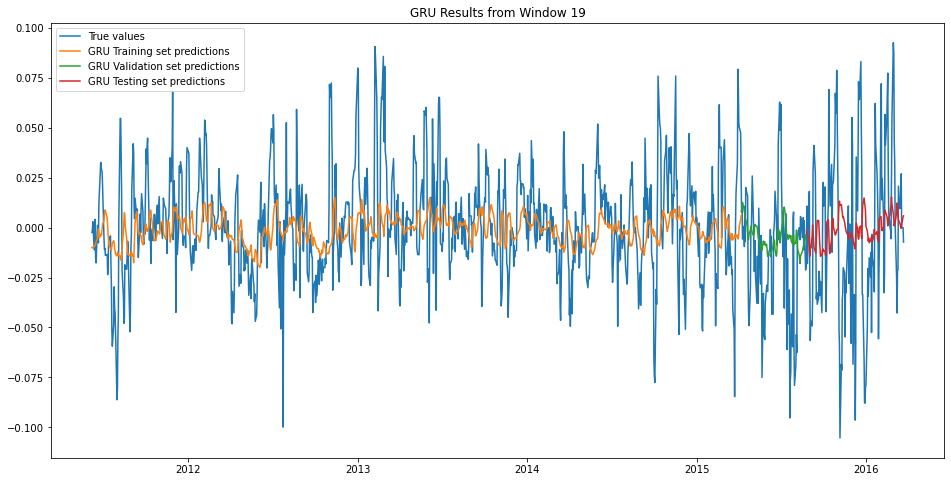

Window 20: 
Training datapoints: 2850 - 3849
Validation datapoints: 3850 - 3949
Testing datapoints: 3950 - 4099

Results on Training set: 
MSE = 0.0006030257254134247
RMSE = 0.02455658211994138
MAE = 0.01812859788280375
R-Squared = 0.17430133450437857

Results on Validation set: 
MSE = 0.0020619169307190843
RMSE = 0.04540833547619957
MAE = 0.036153299345442064
R-Squared = -0.011633443063227666

Results on Testing set: 
MSE = 0.001278325757085915
RMSE = 0.03575368172770344
MAE = 0.028257355234584693
R-Squared = -0.2549458471437551



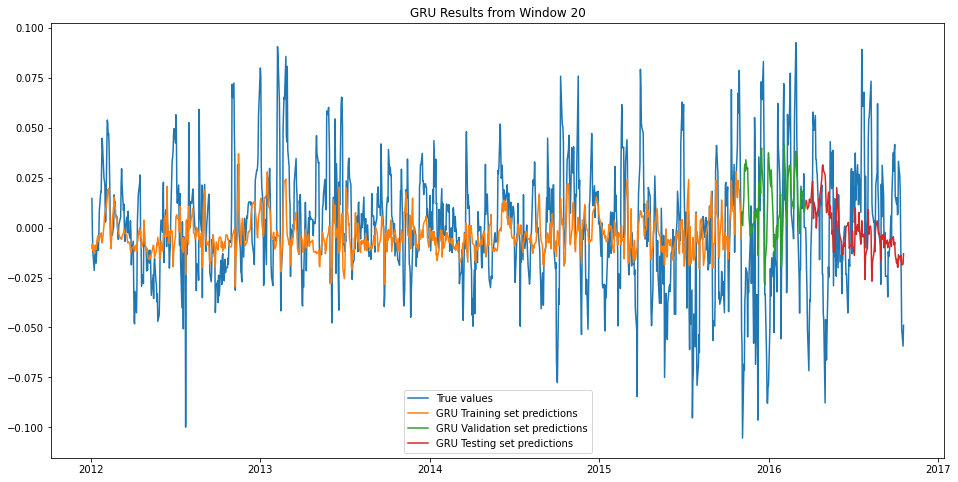

Window 21: 
Training datapoints: 3000 - 3999
Validation datapoints: 4000 - 4099
Testing datapoints: 4100 - 4249

Results on Training set: 
MSE = 0.0008558033871492073
RMSE = 0.029254117439246177
MAE = 0.021813660175622893
R-Squared = 0.060817387949115176

Results on Validation set: 
MSE = 0.0007486140527038557
RMSE = 0.027360812354604087
MAE = 0.021222644058631474
R-Squared = 0.08416005172671248

Results on Testing set: 
MSE = 0.00045913683203539687
RMSE = 0.021427478433903437
MAE = 0.016980183825934858
R-Squared = -0.19171279629985438



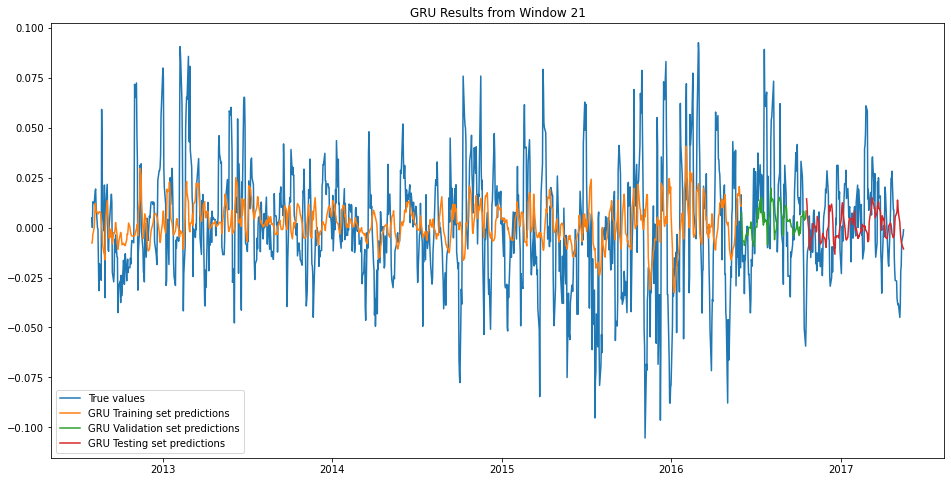

Window 22: 
Training datapoints: 3150 - 4149
Validation datapoints: 4150 - 4249
Testing datapoints: 4250 - 4399

Results on Training set: 
MSE = 0.0008732026435619747
RMSE = 0.029550002429136527
MAE = 0.022358445206562196
R-Squared = 0.0025933709826131413

Results on Validation set: 
MSE = 0.00043368573030155616
RMSE = 0.020825122575907115
MAE = 0.016496213115752553
R-Squared = -0.003435048876862412

Results on Testing set: 
MSE = 0.0007977508990110378
RMSE = 0.028244484399808714
MAE = 0.020620782175858395
R-Squared = -0.1296078030397525



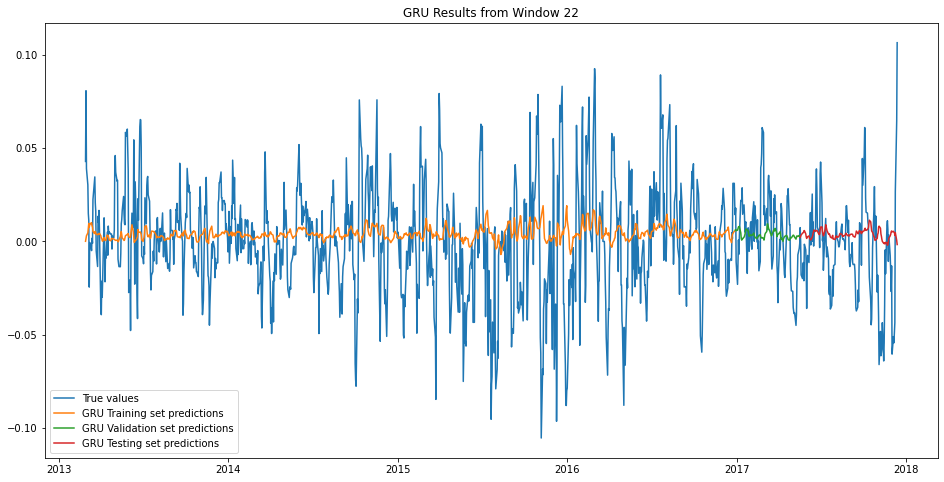

Window 23: 
Training datapoints: 3300 - 4299
Validation datapoints: 4300 - 4399
Testing datapoints: 4400 - 4549

Results on Training set: 
MSE = 0.0008897058328091477
RMSE = 0.029827937119572108
MAE = 0.02289398371882111
R-Squared = -0.045190194361020675

Results on Validation set: 
MSE = 0.0009321725087491446
RMSE = 0.03053150027019872
MAE = 0.0220664765786356
R-Squared = -0.0614037930185618

Results on Testing set: 
MSE = 0.0011742360052657578
RMSE = 0.03426712718139292
MAE = 0.025683507215026893
R-Squared = -0.17333969145081674



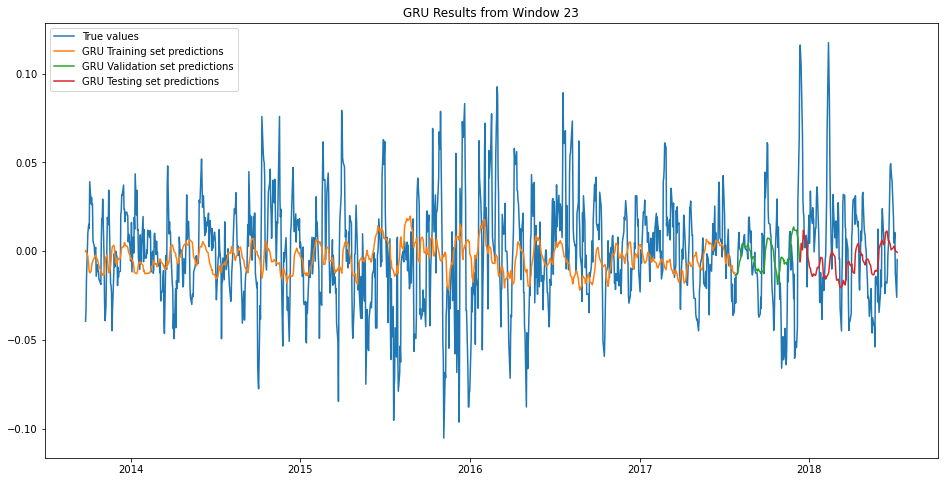

Window 24: 
Training datapoints: 3450 - 4449
Validation datapoints: 4450 - 4549
Testing datapoints: 4550 - 4699

Results on Training set: 
MSE = 0.0005069728488933577
RMSE = 0.02251605757883377
MAE = 0.016384785955300872
R-Squared = 0.483242718316534

Results on Validation set: 
MSE = 0.0006066053623888796
RMSE = 0.024629359764088057
MAE = 0.020356386307437416
R-Squared = -8.571277581070902e-05

Results on Testing set: 
MSE = 0.0009244008373281326
RMSE = 0.030403960882229353
MAE = 0.02375640385664796
R-Squared = -0.01048552279200976



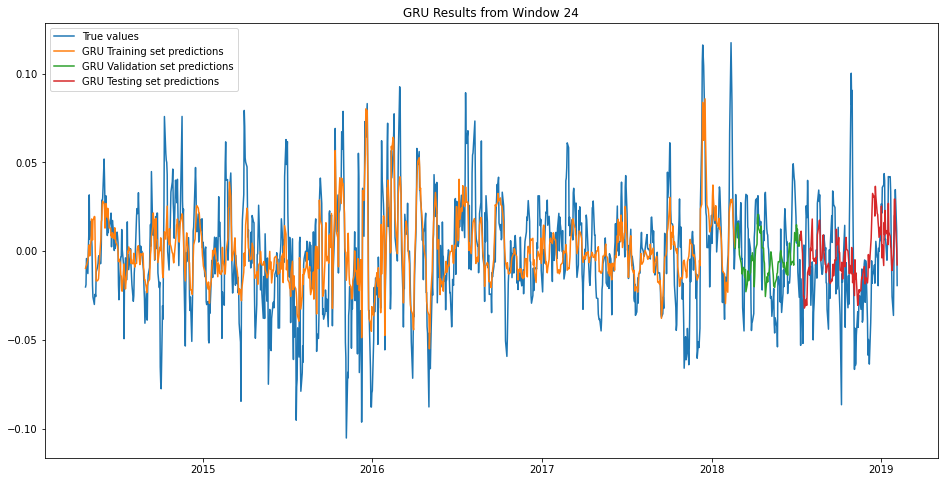

Window 25: 
Training datapoints: 3600 - 4599
Validation datapoints: 4600 - 4699
Testing datapoints: 4700 - 4929

Results on Training set: 
MSE = 0.0006051501263048673
RMSE = 0.024599799314320988
MAE = 0.018571202912198777
R-Squared = 0.3778000288111222

Results on Validation set: 
MSE = 0.0008843707755199125
RMSE = 0.02973837210608396
MAE = 0.02252267248806428
R-Squared = 0.20101542115867532

Results on Testing set: 
MSE = 0.0010102053095210068
RMSE = 0.03178372711814974
MAE = 0.02431662471370732
R-Squared = -0.4286863634375093



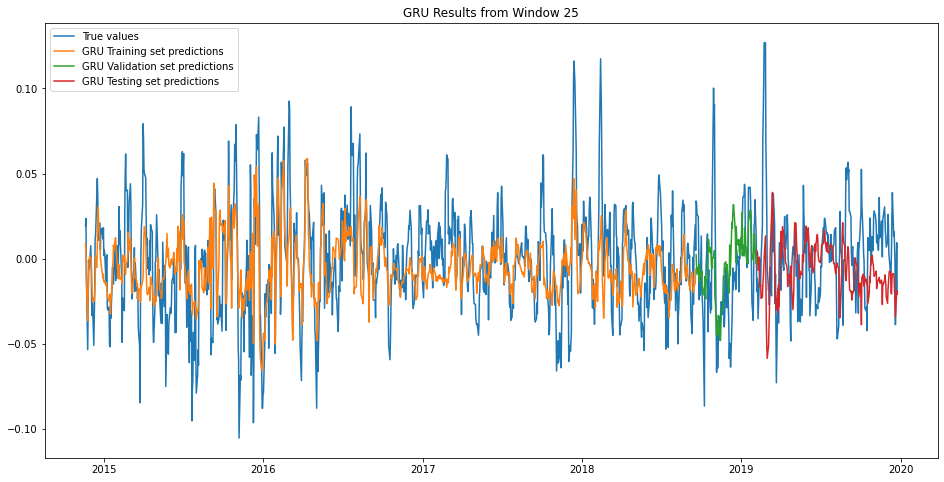

In [10]:
#Declaring model parameters
sequencelength = 189
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength
gru_predictions = np.zeros((numPredictions + extra,1)) 
gru_target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra

  #Print window information
  windowInfo(w, sequencelength, start, trainingSize, validationSize, end)
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #Create, train and test GRU 
  gru_model = create_gru()
  gru_history, gru_model = train_gru(gru_model, x_train, y_train, x_val, y_val)
  gru_predictions, gru_trainingPredictions, gru_valPredictions, gru_testingPredictions = makePredictions(gru_model, gru_predictions, x_train, x_val, x_test)
  evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, gru_trainingPredictions, gru_valPredictions, gru_testingPredictions)

  gru_target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Plot graph of forecasts
  trainGraph = pd.DataFrame(df[start : start + trainingSize])
  trainGraph['GRU Train Predictions'] = gru_trainingPredictions
  valGraph = pd.DataFrame(df[start + trainingSize : end - testingSize])
  valGraph['GRU Val Predictions'] = gru_valPredictions
  testGraph = pd.DataFrame(df[start + trainingSize + validationSize : end])
  testGraph['GRU Test Predictions'] = gru_testingPredictions
  
  #Plot GRU Results
  plt.figure(figsize=(16,8))
  plt.plot(df['Target'][start : end], label='True values')
  plt.plot(trainGraph['GRU Train Predictions'], label = 'GRU Training set predictions')
  plt.plot(valGraph['GRU Val Predictions'], label = 'GRU Validation set predictions')
  plt.plot(testGraph['GRU Test Predictions'], label = 'GRU Testing set predictions')
  plt.title("GRU Results from Window " + str(w + 1))
  plt.legend(loc = 'best')
  plt.show()

  #Update window parameters
  start += testingSize
  end += testingSize

**Naive and Drift Forecasting Implementation**

In [11]:
def naiveForecasts(dataset, begin, horizon, testingSize):
  '''
  Naive forecasting model
  @params:
    dataset - data to be used
    begin - Index of the test set
    testingSize - Size of the test set
  @returns:
    naive - forecasts for the window
  '''
  naive = dataset[begin-horizon:begin+testingSize-horizon,0].copy()
  return naive.reshape((naive.shape[0],1))

def driftForecasts(dataset, begin, horizon, testingSize):
  '''
  Drift forecasting model
  @params:
    dataset - data to be used
    begin - Index of the test set
    horizon - Size of the forecasting Horizon
    testingSize - Size of the test set
  @returns:
    drift - forecasts for the window
  '''
  drift = dataset[begin-horizon:begin+testingSize-horizon,0].copy()
  for i in range(2, drift.shape[0] + 1): 
    drift[i - 1] = drift[i - 1] + horizon * ((drift[i - 1] - drift[0]) / (i - 1))
  return drift.reshape((drift.shape[0],1))

#Declaring model parameters
sequencelength = 100
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength 
naive_predictions = np.zeros((numPredictions + extra,1)) 
drift_predictions = np.zeros((numPredictions + extra,1)) 
target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #naive and drift forecasts
  begin = start + trainingSize + validationSize
  naive_predictions[start - sequencelength: start - sequencelength + testingSize, :] = naiveForecasts(dataset, begin, forecastHorizon, testingSize)
  drift_predictions[start - sequencelength: start - sequencelength + testingSize, :] = driftForecasts(dataset, begin, forecastHorizon, testingSize)
  target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Update window parameters
  start += testingSize
  end += testingSize

print("Naive and Drift Forecasts completed")

Naive and Drift Forecasts completed


**Overall Results**

In [12]:
def overall(actual, predictions, model):
  '''
  Calculate the overall performance of the model
  @params:
    actual - True Values
    predictions - Predicted Values
    model - Name of the model used
  '''
  mse = mean_squared_error(actual, predictions)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(actual, predictions)
  r2 = r2_score(actual, predictions)

  print(model + " results on the Testing set")
  print('MSE = ' + str(mse))
  print('RMSE = ' + str(rmse))
  print('MAE = ' + str(mae))
  print('R-Squared = ' + str(r2))
  print()

#Performance Metrics
overall(lstm_target, lstm_predictions, "LSTM model")
overall(gru_target, gru_predictions, "GRU model")
overall(target, naive_predictions, "Naive model")
overall(target, drift_predictions, "Drift model")

#For Plots
numpreds = 0
if lstm_predictions.shape[0] <= gru_predictions.shape[0]:
  numpreds = lstm_predictions.shape[0]
else:
  numpreds = gru_predictions.shape[0]

testGraph = pd.DataFrame(df[-numpreds:]['Target'])
testGraph['LSTM'] = lstm_predictions[-numpreds:]
testGraph['GRU'] = gru_predictions[-numpreds:]
testGraph['Naive'] = naive_predictions[-numpreds:]
testGraph['Drift'] = drift_predictions[-numpreds:]

LSTM model results on the Testing set
MSE = 0.0014582398365367566
RMSE = 0.0381869066112556
MAE = 0.027846411307627637
R-Squared = -0.5561965757732492

GRU model results on the Testing set
MSE = 0.00108498564977369
RMSE = 0.03293912035518997
MAE = 0.02487850197293778
R-Squared = -0.16073378415554607

Naive model results on the Testing set
MSE = 0.001962561554690936
RMSE = 0.044300807607660336
MAE = 0.03346928813863024
R-Squared = -1.0728277597806088

Drift model results on the Testing set
MSE = 0.0023515702779735373
RMSE = 0.04849299205012553
MAE = 0.03637780049224236
R-Squared = -1.483692875572594



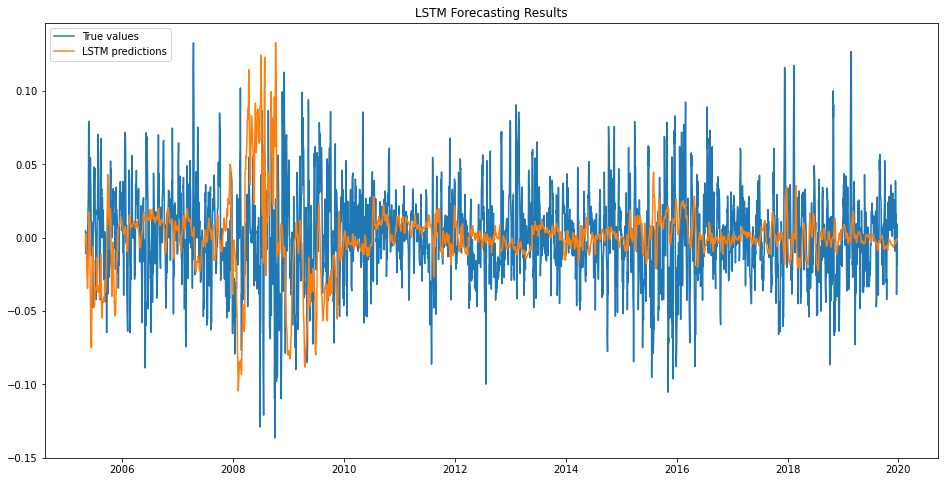

In [13]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['LSTM'], label = 'LSTM predictions')
plt.title("LSTM Forecasting Results")
plt.legend()
plt.show()

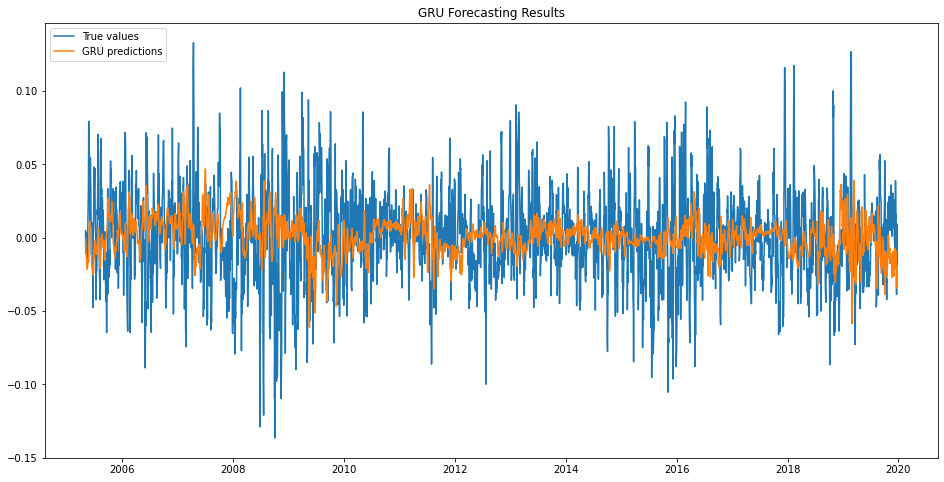

In [14]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['GRU'], label = 'GRU predictions')
plt.title("GRU Forecasting Results")
plt.legend()
plt.show()

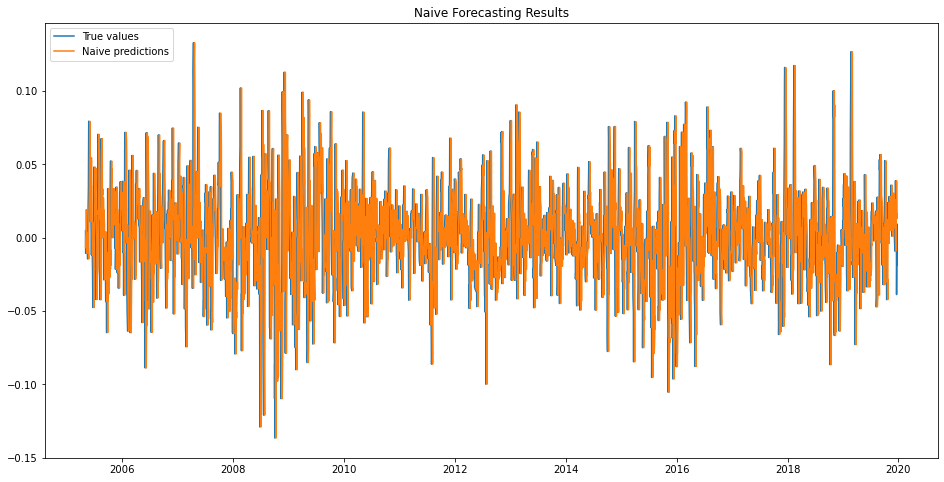

In [15]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['Naive'], label = 'Naive predictions')
plt.title("Naive Forecasting Results")
plt.legend()
plt.show()

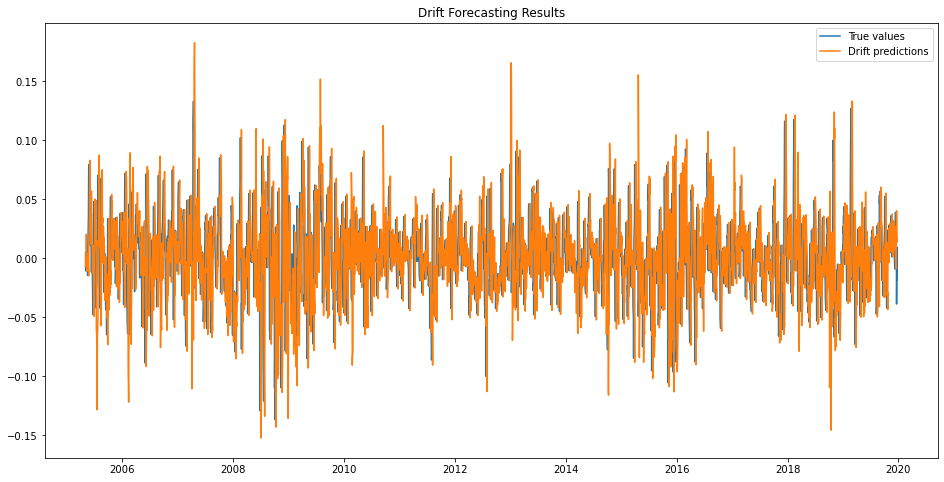

In [16]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['Drift'], label = 'Drift predictions')
plt.title("Drift Forecasting Results")
plt.legend()
plt.show()

**Save the predictions to a csv file**

In [17]:
savePredictions = pd.DataFrame(df[-numpreds:]['Target'])

savePredictions['AFE LSTM'] = lstm_predictions[-numpreds:]
savePredictions['AFE GRU'] = gru_predictions[-numpreds:]
savePredictions['AFE Naive'] = naive_predictions[-numpreds:]
savePredictions['AFE Drift'] = drift_predictions[-numpreds:]
savePredictions.drop(['Target'], axis=1, inplace=True)

savePredictions.to_csv(r'./AFE_Predictions.csv', index=True, header=True)

In [18]:
savePredictions.head()

AFE LSTM   AFE GRU  AFE Naive  AFE Drift
Date                                                
2005-05-05 -0.004497 -0.000888  -0.006741  -0.006803
2005-05-06 -0.000294 -0.005278   0.000965   0.001284
2005-05-09  0.002902 -0.010528   0.001446   0.001787
2005-05-10 -0.000264 -0.011661   0.019085   0.020278
2005-05-11 -0.007177 -0.013000   0.018127   0.019263